In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/test-case-1/Dataset 1.mp4
/kaggle/input/asl-dataset/asl_dataset/n/hand2_n_dif_seg_3_cropped.jpeg
/kaggle/input/asl-dataset/asl_dataset/n/hand1_n_left_seg_5_cropped.jpeg
/kaggle/input/asl-dataset/asl_dataset/n/hand2_n_top_seg_4_cropped.jpeg
/kaggle/input/asl-dataset/asl_dataset/n/hand1_n_dif_seg_2_cropped.jpeg
/kaggle/input/asl-dataset/asl_dataset/n/hand2_n_top_seg_1_cropped.jpeg
/kaggle/input/asl-dataset/asl_dataset/n/hand3_n_dif_seg_1_cropped.jpeg
/kaggle/input/asl-dataset/asl_dataset/n/hand2_n_dif_seg_2_cropped.jpeg
/kaggle/input/asl-dataset/asl_dataset/n/hand2_n_top_seg_3_cropped.jpeg
/kaggle/input/asl-dataset/asl_dataset/n/hand5_n_dif_seg_4_cropped.jpeg
/kaggle/input/asl-dataset/asl_dataset/n/hand1_n_right_seg_5_cropped.jpeg
/kaggle/input/asl-dataset/asl_dataset/n/hand1_n_left_seg_1_cropped.jpeg
/kaggle/input/asl-dataset/asl_dataset/n/hand2_n_right_seg_4_cropped.jpeg
/kaggle/input/asl-dataset/asl_dataset/n/hand1_n_right_seg_3_cropped.jpeg
/kaggle/input/asl-dataset/asl

In [2]:
!pip install mediapipe

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.9/35.9 MB 45.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 20.1 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
apache-beam 2.46.0 requires cloudpickle~=2.2.1, but you have cloudpickle 3.0.0 which is incompatible.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.8 which is incompatible.
apache-beam 2.46.0 requires numpy<1.25.0,>=1.14.3, but you have numpy 1.26.4 which is incompatible.
apache-beam 2.46.0 requires protobuf<4,>3.12.2, but you have protobuf 4.25.4 which is incompatible.
apache-beam 2.46.0 requires pyarrow<10.0.0,>=3.0.0, but you have pyarrow 16.1.0 which is inc

In [3]:
import keras
import os
import numpy as np
import cv2
from PIL import Image, ImageFilter,ImageOps
from sklearn.model_selection import train_test_split
import random
import mediapipe as mp
import matplotlib.pyplot as plt
import warnings
import logging
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Input, Flatten
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam 
from sklearn.metrics import precision_recall_fscore_support
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Dropout, BatchNormalization
from sklearn.metrics import precision_score, recall_score, f1_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, TimeDistributed
from tensorflow.keras.layers import Lambda
from tensorflow.keras.applications import ResNet50
from tensorflow import keras
from tensorflow.keras import layers

In [4]:
# Function to detect landmarks
def detect_landmarks(image):
    mp_hands = mp.solutions.hands
    mp_drawing = mp.solutions.drawing_utils

    # Initialize MediaPipe Hands
    with mp_hands.Hands(static_image_mode=True, max_num_hands=2, min_detection_confidence=0.7) as hands:
        # Add a border to the image
        border_color = (0, 0, 0)  # Black color
        border_width = 250
        image_with_border = cv2.copyMakeBorder(image, border_width, border_width, border_width, border_width, cv2.BORDER_CONSTANT, value=border_color)

        # Convert image with border to RGB (MediaPipe uses RGB format)
        image_with_border_rgb = cv2.cvtColor(image_with_border, cv2.COLOR_BGR2RGB)

        # Process image
        results = hands.process(image_with_border_rgb)

        # Placeholder for landmarks if no hands are detected
        placeholder_landmarks = None

        # Check if hands are detected
        if results.multi_hand_landmarks:
            # Draw landmarks on the image
            annotated_image = image_with_border.copy()
            for hand_landmarks in results.multi_hand_landmarks:
                mp_drawing.draw_landmarks(annotated_image, hand_landmarks, mp_hands.HAND_CONNECTIONS)
            
            # Crop the border out before returning the image
            height, width, _ = image.shape
            cropped_image = annotated_image[border_width:border_width+height, border_width:border_width+width]
            return cropped_image
        else:
            print("No hands detected in the image.")
            return image 

# Function to preprocess image
def preprocess_image(image, target_size=(224, 224)):
    # Preprocess the image
    preprocessed_image = cv2.resize(image, target_size)
    preprocessed_image = preprocessed_image / 255.0
    preprocessed_image = (preprocessed_image * 255).astype(np.uint8)
    
    if np.random.rand() > 0.5:
        preprocessed_image = cv2.flip(preprocessed_image, 1)
    if np.random.rand() > 0.5:
        preprocessed_image = cv2.flip(preprocessed_image, 0)
    if np.random.rand() > 0.5:
        angle = np.random.uniform(-15, 15)
        M = cv2.getRotationMatrix2D((target_size[0] // 2, target_size[1] // 2), angle, 1)
        preprocessed_image = cv2.warpAffine(preprocessed_image, M, (target_size[0], target_size[1]))
    if np.random.rand() > 0.5:
        zoom_factor = np.random.uniform(0.9, 1.1)
        preprocessed_image = cv2.resize(preprocessed_image, None, fx=zoom_factor, fy=zoom_factor)
        if zoom_factor < 1.0:
            pad_h = (target_size[0] - preprocessed_image.shape[0]) // 2
            pad_w = (target_size[1] - preprocessed_image.shape[1]) // 2
            preprocessed_image = cv2.copyMakeBorder(preprocessed_image, pad_h, pad_h, pad_w, pad_w, cv2.BORDER_CONSTANT, value=[0, 0, 0])
        else:
            crop_h = (preprocessed_image.shape[0] - target_size[0]) // 2
            crop_w = (preprocessed_image.shape[1] - target_size[1]) // 2
            preprocessed_image = preprocessed_image[crop_h:crop_h+target_size[0], crop_w:crop_w+target_size[1]]
    if np.random.rand() > 0.5:
        translation = np.random.uniform(-10, 10, 2)
        M = np.float32([[1, 0, translation[0]], [0, 1, translation[1]]])
        preprocessed_image = cv2.warpAffine(preprocessed_image, M, (target_size[0], target_size[1]))
    preprocessed_image = cv2.GaussianBlur(preprocessed_image, (5, 5), 0)
    
    return preprocessed_image

# Function to load data
def load_data(directory, target_size=(224, 224)):
    images = []
    labels = []
    classes = os.listdir(directory)
    for idx, folder in enumerate(classes):
        folder_path = os.path.join(directory, folder)
        for image_name in os.listdir(folder_path):
            image_path = os.path.join(folder_path, image_name)
            image = cv2.imread(image_path)
            if image is not None:
                # Apply hand landmark detection and preprocessing
                preprocessed_image = detect_landmarks(image)
                if preprocessed_image is None:
                    # If no hands detected, preprocess without hand landmarks
                    preprocessed_image = preprocess_image(image)
                else:
                    # If hands detected, preprocess the annotated image
                    preprocessed_image = preprocess_image(preprocessed_image)
                
                # Resize the preprocessed image to target size
                preprocessed_image = cv2.resize(preprocessed_image, target_size)

                images.append(preprocessed_image)
                labels.append(idx)
    return np.array(images), np.array(labels)

In [5]:
# Set TensorFlow logging level
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # 0 = all logs, 1 = filter INFO, 2 = filter WARNING, 3 = filter ERROR

# Suppress warnings from the warnings module
warnings.filterwarnings('ignore')

# Suppress absl-py logging
logging.getLogger('absl').setLevel(logging.ERROR)

# Optionally, if using TensorFlow Lite Interpreter
# Set verbosity level for TensorFlow Lite logs (only works with TensorFlow 2.3 and later)
if hasattr(tf, 'lite'):
    from tensorflow.lite.python.interpreter import Interpreter

    # Custom Interpreter class to suppress TFLite logs
    class QuietInterpreter(Interpreter):
        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            self._delegate_options.update({'--log-level': 'FATAL'})
            
dataset_dir = "/kaggle/input/asl-dataset/asl_dataset/asl_dataset"
X, y = load_data(dataset_dir)

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1725857230.373403     113 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857230.402354     113 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857230.412402     113 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.
W0000 00:00:1725857230.481618     118 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857230.510192     118 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:

No hands detected in the image.


W0000 00:00:1725857233.315399     284 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857233.327659     285 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857233.373390     288 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857233.385497     288 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857233.428445     292 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857233.444959     291 inference_feedback_manager.cc:114] Feedback manager 

No hands detected in the image.


W0000 00:00:1725857234.003355     332 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857234.015333     332 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857234.058667     336 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857234.071942     337 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857234.117679     340 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857234.130139     341 inference_feedback_manager.cc:114] Feedback manager 

No hands detected in the image.


W0000 00:00:1725857235.311005     420 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857235.325166     420 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857235.368933     423 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857235.381292     424 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857235.429343     428 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857235.446150     426 inference_feedback_manager.cc:114] Feedback manager 

No hands detected in the image.


W0000 00:00:1725857236.828560     521 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857236.840106     519 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857236.889216     524 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857236.902413     524 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857236.949880     527 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857236.961999     527 inference_feedback_manager.cc:114] Feedback manager 

No hands detected in the image.


W0000 00:00:1725857237.054025     536 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857237.070496     534 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857237.114807     540 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857237.135030     540 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857237.175810     542 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857237.193284     542 inference_feedback_manager.cc:114] Feedback manager 

No hands detected in the image.


W0000 00:00:1725857237.977892     600 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857237.990251     600 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857238.036857     603 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857238.049094     602 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857238.093316     608 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857238.104749     606 inference_feedback_manager.cc:114] Feedback manager 

No hands detected in the image.


W0000 00:00:1725857241.782050     852 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857241.794594     853 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857241.837758     854 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857241.849750     854 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857241.894693     858 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857241.906871     858 inference_feedback_manager.cc:114] Feedback manager 

No hands detected in the image.
No hands detected in the image.


W0000 00:00:1725857243.564452     974 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857243.576493     974 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857243.620738     980 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857243.632626     980 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857243.661191     984 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857243.673305     984 inference_feedback_manager.cc:114] Feedback manager 

No hands detected in the image.


W0000 00:00:1725857244.895471    1069 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857244.908151    1069 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857244.956439    1072 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857244.968392    1070 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857245.012902    1075 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857245.025281    1075 inference_feedback_manager.cc:114] Feedback manager 

No hands detected in the image.


W0000 00:00:1725857245.354712    1099 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857245.373246    1099 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857245.422219    1103 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857245.439735    1105 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857245.488641    1106 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857245.500442    1107 inference_feedback_manager.cc:114] Feedback manager 

No hands detected in the image.


W0000 00:00:1725857245.841537    1132 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857245.858639    1132 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857245.911145    1134 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857245.931459    1136 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857245.974646    1140 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857245.986953    1140 inference_feedback_manager.cc:114] Feedback manager 

No hands detected in the image.
No hands detected in the image.


W0000 00:00:1725857248.346008    1291 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857248.362976    1291 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857248.405987    1294 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857248.422255    1297 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857248.451145    1298 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857248.463508    1299 inference_feedback_manager.cc:114] Feedback manager 

No hands detected in the image.


W0000 00:00:1725857249.041693    1335 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857249.057525    1335 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857249.104322    1338 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857249.116166    1338 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857249.175252    1343 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857249.187321    1343 inference_feedback_manager.cc:114] Feedback manager 

No hands detected in the image.


W0000 00:00:1725857249.477074    1364 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857249.489293    1364 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857249.534131    1368 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857249.547261    1368 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857249.595931    1372 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857249.607968    1371 inference_feedback_manager.cc:114] Feedback manager 

No hands detected in the image.


W0000 00:00:1725857250.428329    1427 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857250.443220    1427 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857250.504114    1433 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857250.517226    1433 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857250.572661    1436 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857250.585725    1437 inference_feedback_manager.cc:114] Feedback manager 

No hands detected in the image.


W0000 00:00:1725857250.640298    1438 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857250.691920    1444 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857250.704523    1443 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857250.751230    1447 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857250.769372    1447 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857250.815361    1452 inference_feedback_manager.cc:114] Feedback manager 

No hands detected in the image.


W0000 00:00:1725857251.783825    1511 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857251.796470    1510 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857251.842957    1516 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857251.855058    1516 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857251.903341    1520 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857251.921754    1518 inference_feedback_manager.cc:114] Feedback manager 

No hands detected in the image.


W0000 00:00:1725857253.669507    1635 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857253.681724    1634 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857253.726403    1639 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857253.743715    1639 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857253.789442    1643 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857253.810809    1643 inference_feedback_manager.cc:114] Feedback manager 

No hands detected in the image.


W0000 00:00:1725857260.588805    2091 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857260.601257    2093 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857260.648984    2097 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857260.661519    2096 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857260.705451    2100 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857260.723697    2100 inference_feedback_manager.cc:114] Feedback manager 

No hands detected in the image.


W0000 00:00:1725857261.259199    2136 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857261.271727    2134 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857261.316054    2140 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857261.328221    2140 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857261.373396    2144 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857261.389419    2144 inference_feedback_manager.cc:114] Feedback manager 

No hands detected in the image.


W0000 00:00:1725857262.843389    2239 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857262.860938    2239 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857262.914347    2243 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857262.933387    2246 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857262.981129    2247 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857262.996140    2249 inference_feedback_manager.cc:114] Feedback manager 

No hands detected in the image.


W0000 00:00:1725857263.054703    2251 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857263.107015    2257 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857263.126108    2257 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857263.175943    2261 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857263.194652    2262 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857263.243112    2264 inference_feedback_manager.cc:114] Feedback manager 

No hands detected in the image.


W0000 00:00:1725857263.769454    2300 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857263.787307    2300 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857263.820631    2304 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857263.832894    2304 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857263.876699    2309 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857263.888978    2309 inference_feedback_manager.cc:114] Feedback manager 

No hands detected in the image.


W0000 00:00:1725857263.990842    2315 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857264.005528    2315 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857264.050342    2321 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857264.062267    2321 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857264.106701    2325 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857264.118658    2325 inference_feedback_manager.cc:114] Feedback manager 

No hands detected in the image.


W0000 00:00:1725857269.404789    2673 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857269.417207    2673 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857269.460359    2675 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857269.471995    2675 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857269.518650    2679 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857269.530594    2680 inference_feedback_manager.cc:114] Feedback manager 

No hands detected in the image.
No hands detected in the image.


W0000 00:00:1725857269.867142    2705 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857269.879568    2706 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857269.922301    2708 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857269.934558    2710 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857269.980282    2711 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857269.993082    2711 inference_feedback_manager.cc:114] Feedback manager 

No hands detected in the image.


W0000 00:00:1725857271.690870    2826 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857271.706044    2826 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857271.748070    2827 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857271.759953    2827 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857271.807290    2832 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857271.819453    2833 inference_feedback_manager.cc:114] Feedback manager 

No hands detected in the image.


W0000 00:00:1725857272.346765    2865 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857272.368665    2865 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857272.409938    2868 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857272.422364    2869 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857272.485366    2873 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857272.507912    2873 inference_feedback_manager.cc:114] Feedback manager 

No hands detected in the image.


W0000 00:00:1725857272.552722    2876 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857272.598286    2881 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857272.610669    2880 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857272.658370    2884 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857272.674509    2884 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857272.720824    2889 inference_feedback_manager.cc:114] Feedback manager 

No hands detected in the image.


W0000 00:00:1725857273.745419    2956 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857273.758048    2956 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857273.802496    2961 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857273.814898    2959 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857273.859332    2964 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857273.876559    2964 inference_feedback_manager.cc:114] Feedback manager 

No hands detected in the image.


W0000 00:00:1725857275.640919    3084 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857275.653878    3086 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857275.701377    3090 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857275.719262    3090 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857275.767861    3093 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857275.780128    3093 inference_feedback_manager.cc:114] Feedback manager 

No hands detected in the image.


W0000 00:00:1725857275.885573    3100 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857275.904781    3100 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857275.955570    3104 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857275.968116    3104 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857276.013294    3109 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857276.026857    3109 inference_feedback_manager.cc:114] Feedback manager 

No hands detected in the image.


W0000 00:00:1725857277.636971    3221 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857277.649300    3221 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857277.696927    3225 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857277.716413    3224 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857277.767416    3229 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857277.779750    3229 inference_feedback_manager.cc:114] Feedback manager 

No hands detected in the image.
No hands detected in the image.


W0000 00:00:1725857278.114467    3253 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857278.126695    3253 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857278.171627    3258 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857278.184209    3255 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857278.231560    3261 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857278.243597    3261 inference_feedback_manager.cc:114] Feedback manager 

No hands detected in the image.


W0000 00:00:1725857278.997404    3313 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857279.010686    3313 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857279.058612    3317 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857279.071197    3316 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857279.116163    3320 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857279.133437    3320 inference_feedback_manager.cc:114] Feedback manager 

No hands detected in the image.


W0000 00:00:1725857279.708881    3360 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857279.729000    3359 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857279.792451    3363 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857279.807427    3363 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857279.871593    3367 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857279.883877    3367 inference_feedback_manager.cc:114] Feedback manager 

No hands detected in the image.
No hands detected in the image.


W0000 00:00:1725857283.437009    3588 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857283.488697    3592 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857283.503023    3594 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857283.539872    3596 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857283.552551    3598 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857283.603499    3602 inference_feedback_manager.cc:114] Feedback manager 

No hands detected in the image.


W0000 00:00:1725857284.588450    3663 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857284.601002    3665 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857284.645691    3668 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857284.658119    3669 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857284.703523    3672 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857284.721391    3672 inference_feedback_manager.cc:114] Feedback manager 

No hands detected in the image.
No hands detected in the image.
No hands detected in the image.


W0000 00:00:1725857285.259778    3707 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857285.308348    3714 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857285.321135    3714 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857285.356569    3717 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857285.369986    3715 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857285.415592    3720 inference_feedback_manager.cc:114] Feedback manager 

No hands detected in the image.
No hands detected in the image.


W0000 00:00:1725857286.331465    3781 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857286.350182    3780 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857286.399051    3783 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857286.412721    3785 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857286.457472    3788 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857286.474642    3788 inference_feedback_manager.cc:114] Feedback manager 

No hands detected in the image.


W0000 00:00:1725857287.451740    3856 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857287.464337    3857 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857287.509059    3859 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857287.524396    3859 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857287.571607    3865 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857287.588669    3864 inference_feedback_manager.cc:114] Feedback manager 

No hands detected in the image.
No hands detected in the image.


W0000 00:00:1725857289.508311    3993 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857289.520939    3993 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857289.552179    3995 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857289.564847    3997 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857289.612418    4002 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857289.625138    4001 inference_feedback_manager.cc:114] Feedback manager 

No hands detected in the image.


W0000 00:00:1725857289.738617    4007 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857289.751106    4010 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857289.795463    4014 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857289.813650    4012 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857289.861309    4017 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857289.873811    4016 inference_feedback_manager.cc:114] Feedback manager 

No hands detected in the image.


W0000 00:00:1725857289.971907    4023 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857289.990913    4023 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857290.039447    4029 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857290.050923    4029 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857290.098341    4031 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857290.110822    4031 inference_feedback_manager.cc:114] Feedback manager 

No hands detected in the image.
No hands detected in the image.


W0000 00:00:1725857290.203292    4039 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857290.215997    4041 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857290.261501    4044 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857290.273648    4044 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857290.304907    4049 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857290.317418    4050 inference_feedback_manager.cc:114] Feedback manager 

No hands detected in the image.
No hands detected in the image.


W0000 00:00:1725857291.577483    4132 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857291.596214    4134 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857291.644907    4135 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857291.663027    4135 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857291.711486    4140 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857291.723010    4140 inference_feedback_manager.cc:114] Feedback manager 

No hands detected in the image.


W0000 00:00:1725857292.001460    4160 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857292.013801    4160 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857292.060325    4165 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857292.073058    4163 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857292.119211    4168 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857292.131517    4167 inference_feedback_manager.cc:114] Feedback manager 

No hands detected in the image.


W0000 00:00:1725857292.228017    4177 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857292.240337    4177 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857292.288635    4181 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857292.300809    4181 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857292.346003    4184 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857292.364369    4184 inference_feedback_manager.cc:114] Feedback manager 

No hands detected in the image.
No hands detected in the image.


W0000 00:00:1725857292.875492    4221 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857292.888217    4220 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857292.933021    4224 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857292.945160    4224 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857292.991181    4229 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857293.009717    4228 inference_feedback_manager.cc:114] Feedback manager 

No hands detected in the image.
No hands detected in the image.


W0000 00:00:1725857293.801665    4285 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857293.813844    4285 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857293.858973    4288 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857293.871190    4288 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857293.903919    4294 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857293.917462    4292 inference_feedback_manager.cc:114] Feedback manager 

No hands detected in the image.


W0000 00:00:1725857295.618813    4408 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857295.631116    4408 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857295.678410    4412 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857295.690558    4412 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857295.734690    4416 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857295.754381    4416 inference_feedback_manager.cc:114] Feedback manager 

No hands detected in the image.


W0000 00:00:1725857296.119168    4441 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857296.131915    4441 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857296.206451    4445 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857296.218159    4445 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857296.262687    4449 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857296.279695    4449 inference_feedback_manager.cc:114] Feedback manager 

No hands detected in the image.


W0000 00:00:1725857297.752924    4549 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857297.770166    4547 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857297.815760    4552 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857297.828673    4552 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857297.877284    4557 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857297.889205    4557 inference_feedback_manager.cc:114] Feedback manager 

No hands detected in the image.
No hands detected in the image.


W0000 00:00:1725857298.874077    4623 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857298.892309    4623 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857298.942338    4630 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857298.955518    4629 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857299.004122    4633 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857299.016969    4633 inference_feedback_manager.cc:114] Feedback manager 

No hands detected in the image.
No hands detected in the image.


W0000 00:00:1725857299.108669    4641 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857299.121024    4641 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857299.167636    4644 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857299.180000    4644 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857299.210738    4649 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857299.223150    4647 inference_feedback_manager.cc:114] Feedback manager 

No hands detected in the image.
No hands detected in the image.


W0000 00:00:1725857299.543323    4673 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857299.561250    4673 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857299.612575    4677 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857299.624644    4677 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857299.667715    4680 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857299.679986    4681 inference_feedback_manager.cc:114] Feedback manager 

No hands detected in the image.
No hands detected in the image.


W0000 00:00:1725857299.759160    4687 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857299.777266    4688 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857299.823771    4693 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857299.841153    4693 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857299.886781    4697 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857299.898845    4697 inference_feedback_manager.cc:114] Feedback manager 

No hands detected in the image.


W0000 00:00:1725857299.988499    4706 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857300.000683    4706 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857300.046221    4709 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857300.058104    4709 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857300.102778    4712 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857300.115417    4713 inference_feedback_manager.cc:114] Feedback manager 

No hands detected in the image.


W0000 00:00:1725857300.207173    4720 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857300.219340    4720 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857300.264782    4725 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857300.277149    4723 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857300.321202    4729 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857300.333555    4728 inference_feedback_manager.cc:114] Feedback manager 

No hands detected in the image.
No hands detected in the image.


W0000 00:00:1725857301.578179    4812 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857301.590809    4812 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857301.638915    4815 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857301.658099    4818 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857301.706079    4819 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857301.718297    4819 inference_feedback_manager.cc:114] Feedback manager 

No hands detected in the image.


W0000 00:00:1725857301.809096    4829 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857301.821657    4830 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857301.868785    4831 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857301.881048    4831 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857301.929477    4838 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857301.942105    4837 inference_feedback_manager.cc:114] Feedback manager 

No hands detected in the image.
No hands detected in the image.


W0000 00:00:1725857302.039838    4846 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857302.051954    4846 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857302.099016    4849 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857302.111356    4849 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857302.158593    4854 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857302.170853    4854 inference_feedback_manager.cc:114] Feedback manager 

No hands detected in the image.


W0000 00:00:1725857307.162244    5186 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857307.180050    5186 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857307.229145    5190 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857307.240969    5190 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857307.286807    5193 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857307.298613    5193 inference_feedback_manager.cc:114] Feedback manager 

No hands detected in the image.
No hands detected in the image.


W0000 00:00:1725857307.612165    5217 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857307.630606    5217 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857307.688173    5220 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857307.700710    5220 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857307.751494    5225 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857307.763970    5224 inference_feedback_manager.cc:114] Feedback manager 

No hands detected in the image.


W0000 00:00:1725857309.438887    5337 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857309.450775    5337 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857309.495842    5342 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857309.508438    5342 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857309.552357    5345 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857309.570295    5344 inference_feedback_manager.cc:114] Feedback manager 

No hands detected in the image.


W0000 00:00:1725857311.058331    5443 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857311.070698    5446 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857311.116679    5448 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857311.128498    5448 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857311.173400    5454 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857311.185924    5452 inference_feedback_manager.cc:114] Feedback manager 

No hands detected in the image.
No hands detected in the image.


W0000 00:00:1725857320.091418    6012 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857320.103739    6012 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857320.150301    6017 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857320.162932    6016 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857320.194784    6021 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857320.211402    6022 inference_feedback_manager.cc:114] Feedback manager 

No hands detected in the image.
No hands detected in the image.


W0000 00:00:1725857320.316171    6027 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857320.328796    6027 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857320.374460    6034 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857320.386946    6034 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857320.430547    6036 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857320.443086    6036 inference_feedback_manager.cc:114] Feedback manager 

No hands detected in the image.
No hands detected in the image.


W0000 00:00:1725857320.532745    6044 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857320.545272    6044 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857320.597062    6049 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857320.614382    6049 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857320.653515    6053 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857320.666809    6053 inference_feedback_manager.cc:114] Feedback manager 

No hands detected in the image.
No hands detected in the image.


W0000 00:00:1725857321.218220    6088 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857321.231256    6089 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857321.276901    6091 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857321.289454    6093 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857321.322386    6097 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857321.334631    6097 inference_feedback_manager.cc:114] Feedback manager 

No hands detected in the image.


W0000 00:00:1725857321.674997    6121 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857321.687544    6119 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857321.731983    6124 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857321.744116    6124 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857321.792170    6129 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857321.804479    6129 inference_feedback_manager.cc:114] Feedback manager 

No hands detected in the image.
No hands detected in the image.


W0000 00:00:1725857322.618328    6184 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857322.631331    6184 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857322.677147    6188 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857322.689844    6188 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857322.733893    6191 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857322.751098    6191 inference_feedback_manager.cc:114] Feedback manager 

No hands detected in the image.
No hands detected in the image.
No hands detected in the image.


W0000 00:00:1725857323.264839    6228 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857323.277889    6229 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857323.311103    6232 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857323.323829    6231 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857323.369487    6237 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857323.381488    6237 inference_feedback_manager.cc:114] Feedback manager 

No hands detected in the image.
No hands detected in the image.


W0000 00:00:1725857323.483980    6246 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857323.496820    6243 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857323.544963    6248 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857323.557639    6248 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857323.592629    6252 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857323.611108    6251 inference_feedback_manager.cc:114] Feedback manager 

No hands detected in the image.


W0000 00:00:1725857323.974705    6275 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857323.992575    6275 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857324.038699    6280 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857324.051000    6280 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857324.099327    6283 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857324.111237    6283 inference_feedback_manager.cc:114] Feedback manager 

No hands detected in the image.


W0000 00:00:1725857331.839209    6786 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857331.851414    6786 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857331.899815    6788 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857331.912531    6789 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857331.961498    6792 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857331.980022    6792 inference_feedback_manager.cc:114] Feedback manager 

No hands detected in the image.


W0000 00:00:1725857334.088272    6934 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857334.101151    6933 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857334.146249    6937 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857334.158713    6937 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857334.207951    6941 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857334.220158    6941 inference_feedback_manager.cc:114] Feedback manager 

No hands detected in the image.


W0000 00:00:1725857343.947067    7563 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857344.018323    7568 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857344.033768    7568 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857344.107107    7571 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857344.126780    7571 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857344.187780    7576 inference_feedback_manager.cc:114] Feedback manager 

No hands detected in the image.


W0000 00:00:1725857345.785157    7674 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857345.798387    7672 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857345.845122    7677 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857345.863415    7677 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857345.921181    7679 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857345.937961    7679 inference_feedback_manager.cc:114] Feedback manager 

No hands detected in the image.
No hands detected in the image.


W0000 00:00:1725857346.214196    7702 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857346.231071    7702 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857346.265363    7704 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857346.282984    7703 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857346.331483    7708 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857346.344420    7708 inference_feedback_manager.cc:114] Feedback manager 

No hands detected in the image.


W0000 00:00:1725857347.369575    7779 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857347.382575    7781 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857347.426805    7786 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857347.439080    7786 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857347.485587    7790 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857347.503278    7789 inference_feedback_manager.cc:114] Feedback manager 

No hands detected in the image.


W0000 00:00:1725857347.598795    7796 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857347.611480    7798 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857347.655920    7801 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857347.668321    7800 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857347.712650    7805 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857347.724414    7805 inference_feedback_manager.cc:114] Feedback manager 

No hands detected in the image.
No hands detected in the image.
No hands detected in the image.


W0000 00:00:1725857348.276238    7845 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857348.288937    7846 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857348.333847    7848 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857348.346841    7850 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857348.381911    7852 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857348.394113    7852 inference_feedback_manager.cc:114] Feedback manager 

No hands detected in the image.


W0000 00:00:1725857348.499229    7859 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857348.512380    7859 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857348.559413    7863 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857348.571687    7863 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857348.623159    7867 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857348.635919    7869 inference_feedback_manager.cc:114] Feedback manager 

No hands detected in the image.


W0000 00:00:1725857350.810417    8018 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857350.823101    8016 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857350.868165    8021 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857350.883173    8022 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857350.928625    8024 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857350.941444    8025 inference_feedback_manager.cc:114] Feedback manager 

No hands detected in the image.


W0000 00:00:1725857351.301753    8048 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857351.314673    8047 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857351.360740    8052 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857351.373453    8054 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857351.419230    8055 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857351.431503    8055 inference_feedback_manager.cc:114] Feedback manager 

No hands detected in the image.
No hands detected in the image.
No hands detected in the image.


W0000 00:00:1725857354.072685    8232 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857354.090457    8233 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857354.138503    8235 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857354.151265    8236 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857354.181890    8240 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857354.194598    8241 inference_feedback_manager.cc:114] Feedback manager 

No hands detected in the image.
No hands detected in the image.


W0000 00:00:1725857354.288015    8249 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857354.300112    8249 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857354.347415    8254 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857354.360103    8251 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857354.404315    8255 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857354.416455    8255 inference_feedback_manager.cc:114] Feedback manager 

No hands detected in the image.


W0000 00:00:1725857354.756631    8282 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857354.773150    8282 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857354.820102    8286 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857354.836784    8286 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857354.887986    8287 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857354.899922    8287 inference_feedback_manager.cc:114] Feedback manager 

No hands detected in the image.


W0000 00:00:1725857355.169667    8309 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857355.187899    8310 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857355.233773    8314 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857355.250730    8314 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857355.294888    8316 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857355.306748    8316 inference_feedback_manager.cc:114] Feedback manager 

No hands detected in the image.


W0000 00:00:1725857355.405585    8324 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857355.422358    8324 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857355.471102    8330 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857355.483326    8330 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857355.527648    8332 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857355.545330    8332 inference_feedback_manager.cc:114] Feedback manager 

No hands detected in the image.
No hands detected in the image.


W0000 00:00:1725857355.816367    8351 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857355.828596    8351 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857355.883895    8355 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857355.903039    8355 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857355.953644    8361 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857355.966017    8360 inference_feedback_manager.cc:114] Feedback manager 

No hands detected in the image.


W0000 00:00:1725857356.687862    8405 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857356.700739    8404 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857356.732105    8407 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857356.744554    8409 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857356.789206    8414 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857356.801180    8414 inference_feedback_manager.cc:114] Feedback manager 

No hands detected in the image.


W0000 00:00:1725857356.916292    8420 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857356.929280    8420 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857356.978285    8426 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857356.990234    8426 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857357.048368    8430 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857357.060865    8430 inference_feedback_manager.cc:114] Feedback manager 

No hands detected in the image.


W0000 00:00:1725857357.158459    8436 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857357.171204    8437 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857357.214427    8442 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857357.226335    8442 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857357.270227    8443 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857357.282965    8444 inference_feedback_manager.cc:114] Feedback manager 

No hands detected in the image.


W0000 00:00:1725857367.707936    9132 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857367.720938    9133 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857367.765877    9135 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857367.778375    9136 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857367.827481    9140 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857367.845633    9139 inference_feedback_manager.cc:114] Feedback manager 

No hands detected in the image.


W0000 00:00:1725857368.664598    9195 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857368.677344    9197 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857368.721289    9200 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857368.737437    9200 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857368.783087    9204 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857368.795464    9204 inference_feedback_manager.cc:114] Feedback manager 

No hands detected in the image.


W0000 00:00:1725857369.098523    9225 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857369.144451    9229 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857369.157280    9227 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857369.203677    9234 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857369.216533    9232 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857369.249897    9235 inference_feedback_manager.cc:114] Feedback manager 

No hands detected in the image.


W0000 00:00:1725857369.306752    9239 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857369.319206    9240 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857369.365976    9245 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857369.378127    9245 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857369.423790    9248 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857369.440834    9248 inference_feedback_manager.cc:114] Feedback manager 

No hands detected in the image.


W0000 00:00:1725857370.219456    9301 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857370.236038    9300 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857370.268765    9303 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857370.280980    9303 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857370.326528    9308 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857370.339220    9310 inference_feedback_manager.cc:114] Feedback manager 

No hands detected in the image.


W0000 00:00:1725857370.448530    9317 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857370.460463    9317 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857370.505208    9319 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857370.523693    9319 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857370.571759    9324 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857370.583499    9324 inference_feedback_manager.cc:114] Feedback manager 

No hands detected in the image.


W0000 00:00:1725857372.068432    9423 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857372.080403    9423 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857372.124607    9428 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857372.137312    9428 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857372.181218    9433 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857372.193509    9433 inference_feedback_manager.cc:114] Feedback manager 

No hands detected in the image.


W0000 00:00:1725857377.701166    9779 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857377.713556    9779 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857377.760228    9784 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857377.772477    9784 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857377.818303    9787 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725857377.830424    9787 inference_feedback_manager.cc:114] Feedback manager 

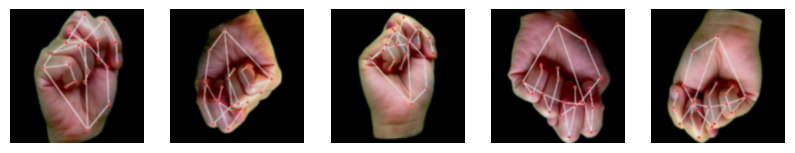

In [6]:
plt.figure(figsize=(10, 10))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(cv2.cvtColor(X[i], cv2.COLOR_BGR2RGB))
    plt.axis('off')
plt.show()

In [7]:
encoder = OneHotEncoder(sparse_output = False)
y_encoded = encoder.fit_transform(y.reshape(-1,1))
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size =0.2, random_state= 42)

In [8]:
def create_baseline_model(input_shape, num_classes):
    model = Sequential([
        Input(shape=input_shape),         # Input layer with specified input shape
        Flatten(),                        # Flatten the input data
        Dense(64, activation='relu'),     # Dense layer with 64 units and ReLU activation
        Dense(num_classes, activation='softmax')  # Output layer with softmax activation for classification
    ])
    return model
input_shape = (224,224,3)  
num_classes = y_encoded.shape[1]
baseline_model = create_baseline_model(input_shape, num_classes) 

In [9]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Compile the baseline model
baseline_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Fit the baseline model
baseline_history = baseline_model.fit(X_train, y_train, validation_split=0.2, epochs=30, batch_size=32, callbacks=[early_stop])

# Evaluate the baseline model on the test data
baseline_test_loss, baseline_test_accuracy = baseline_model.evaluate(X_test, y_test)
print("Baseline Test Loss:", baseline_test_loss)
print("Baseline Test Accuracy:", baseline_test_accuracy)

# Predict the test set
y_pred_baseline = baseline_model.predict(X_test)
y_pred_classes_baseline = np.argmax(y_pred_baseline, axis=1)
y_true = np.argmax(y_test, axis=1)

# Calculate precision, recall, and F1 score for the baseline model
baseline_precision, baseline_recall, baseline_f1_score, _ = precision_recall_fscore_support(y_true, y_pred_classes_baseline, average='weighted')
print("Baseline Precision:", baseline_precision)
print("Baseline Recall:", baseline_recall)
print("Baseline F1 Score:", baseline_f1_score)

metrics_baseline = {
    'test_loss_baseline_model': baseline_test_loss,
    'test_accuracy_baseline_model': baseline_test_accuracy,
    'val_loss_baseline_model': baseline_history.history['val_loss'][-1],
    'val_accuracy_baseline_model': baseline_history.history['val_accuracy'][-1],
    'precision_baseline_model': baseline_precision,
    'recall_baseline_model': baseline_recall,
    'f1_score_baseline_model': baseline_f1_score
}

print("Metrics saved for baseline model:", metrics_baseline)

Epoch 1/30


I0000 00:00:1725857386.534997   10193 service.cc:145] XLA service 0x7864c000e050 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725857386.535090   10193 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


39/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0375 - loss: 3228.9976

I0000 00:00:1725857387.719095   10193 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.0349 - loss: 2721.6726 - val_accuracy: 0.0199 - val_loss: 3.5840
Epoch 2/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0252 - loss: 3.5832 - val_accuracy: 0.0199 - val_loss: 3.5850
Epoch 3/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0368 - loss: 3.5830 - val_accuracy: 0.0199 - val_loss: 3.5858
Epoch 4/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0338 - loss: 3.5825 - val_accuracy: 0.0199 - val_loss: 3.5867
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.0183 - loss: 3.5837
Baseline Test Loss: 3.5837671756744385
Baseline Test Accuracy: 0.013916500844061375
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Baseline Precision: 0.00019366899991699903
Baseline Recall: 0.013916500994035786
Baseline F1 Score: 0.0003820215959147078
Metrics saved for baseline model: {'test_loss_baseline_model': 3.5837671756744385, 'test_accuracy_baseline_model': 0.013916500844061375, 'val_loss_baseline_model': 3.5867059230804443,

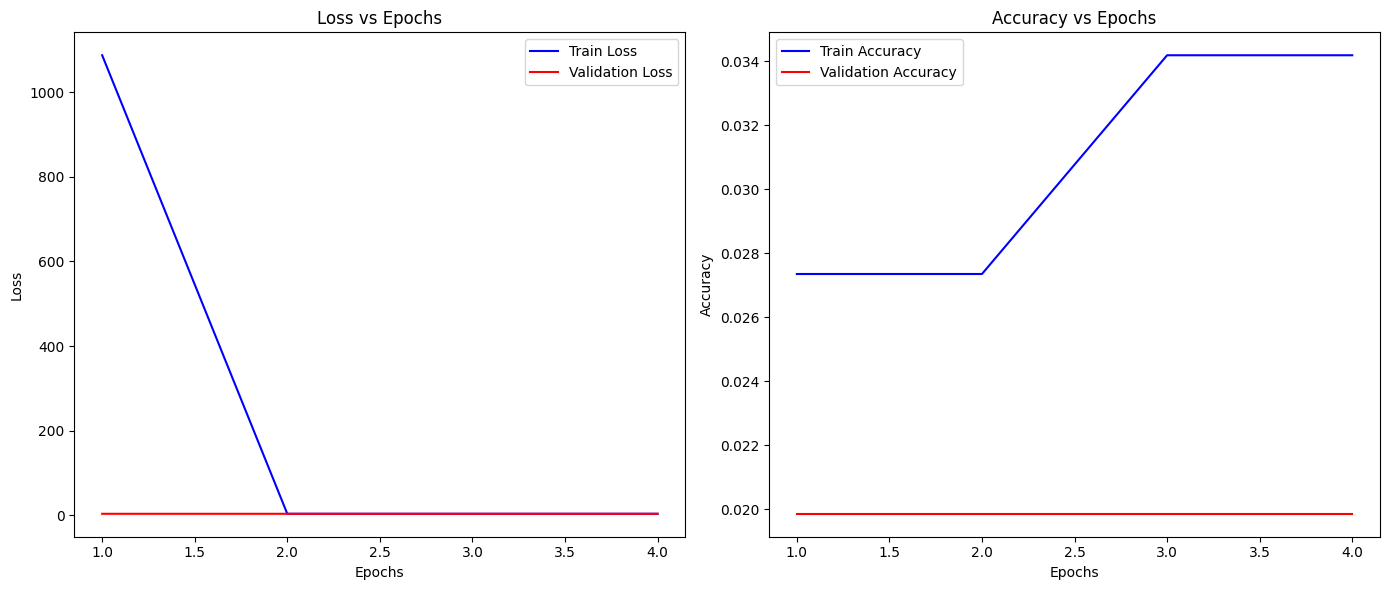

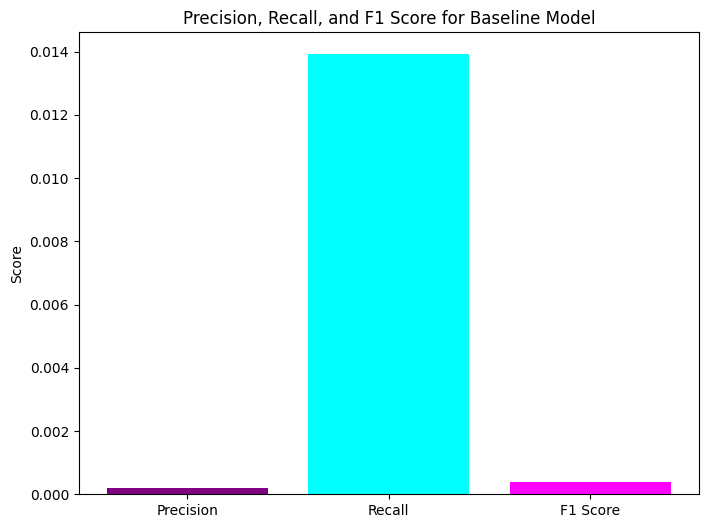

In [10]:
# Retrieve metrics from the baseline history
epochs = range(1, len(baseline_history.history['loss']) + 1)
train_loss = baseline_history.history['loss']
val_loss = baseline_history.history['val_loss']
train_accuracy = baseline_history.history['accuracy']
val_accuracy = baseline_history.history['val_accuracy']

# Create a figure with 2 subplots
plt.figure(figsize=(14, 6))

# Plot Test Loss and Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Train Loss', color='blue')
plt.plot(epochs, val_loss, label='Validation Loss', color='red')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, label='Train Accuracy', color='blue')
plt.plot(epochs, val_accuracy, label='Validation Accuracy', color='red')
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Plot Precision, Recall, and F1 Score
plt.figure(figsize=(8, 6))

# Precision, Recall, and F1 Score
labels = ['Precision', 'Recall', 'F1 Score']
scores = [
    metrics_baseline['precision_baseline_model'],
    metrics_baseline['recall_baseline_model'],
    metrics_baseline['f1_score_baseline_model']
]

plt.bar(labels, scores, color=['purple', 'cyan', 'magenta'])
plt.title('Precision, Recall, and F1 Score for Baseline Model')
plt.ylabel('Score')

plt.show()

In [11]:
def create_advanced_model(input_shape, num_classes):
    model = Sequential([
        Input(shape=input_shape),
        
        # First Convolutional Block
        Conv2D(32, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        
        # Second Convolutional Block
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        
        # Third Convolutional Block
        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        
        # Fourth Convolutional Block
        Conv2D(256, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        
        # Flatten and Fully Connected Layers
        Flatten(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

input_shape = (224, 224, 3)
num_classes = y_encoded.shape[1]
advanced_model = create_advanced_model(input_shape, num_classes)


In [12]:
optimizer = Adam(learning_rate=0.001)

# Compile the model
advanced_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Fit the model
advanced_model_history = advanced_model.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=32)

# Evaluate the model on the test data
test_loss, test_accuracy = advanced_model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Epoch 1/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 35s 320ms/step - accuracy: 0.0449 - loss: 4.5311 - val_accuracy: 0.1141 - val_loss: 3.3958
Epoch 2/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.1356 - loss: 3.3947 - val_accuracy: 0.1340 - val_loss: 3.1667
Epoch 3/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.1866 - loss: 2.9954 - val_accuracy: 0.1414 - val_loss: 3.1811
Epoch 4/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.2542 - loss: 2.5463 - val_accuracy: 0.2109 - val_loss: 2.7954
Epoch 5/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.3277 - loss: 2.2612 - val_accuracy: 0.2630 - val_loss: 2.2629
Epoch 6/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.3797 - loss: 2.0326 - val_accuracy: 0.3201 - val_loss: 2.1973
Epoch 7/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.4106 - loss: 1.8808 - val_accuracy: 0.3325 - val_loss: 2.1487
Epoch 8/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.4435 - loss: 1.7332 - val_accuracy: 

In [13]:
y_pred = np.argmax(advanced_model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

# Calculate precision, recall, and F1 score
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Save all metrics in a dictionary
metrics_adv_model = {
    'test_loss_advanced_model': test_loss,
    'test_accuracy_advanced_model': test_accuracy,
    'val_loss_advanced_model': advanced_model_history.history['val_loss'][-1],
    'val_accuracy_advanced_model': advanced_model_history.history['val_accuracy'][-1],
    'precision_advanced_model': precision,
    'recall_advanced_model': recall,
    'f1_score_advanced_model': f1
}

print("Metrics saved for advanced model:", metrics_adv_model)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
Precision: 0.7635750277450233
Recall: 0.7395626242544732
F1 Score: 0.7373491927480761
Metrics saved for advanced model: {'test_loss_advanced_model': 1.1176759004592896, 'test_accuracy_advanced_model': 0.7395626306533813, 'val_loss_advanced_model': 1.0759457349777222, 'val_accuracy_advanced_model': 0.7419354915618896, 'precision_advanced_model': 0.7635750277450233, 'recall_advanced_model': 0.7395626242544732, 'f1_score_advanced_model': 0.7373491927480761}


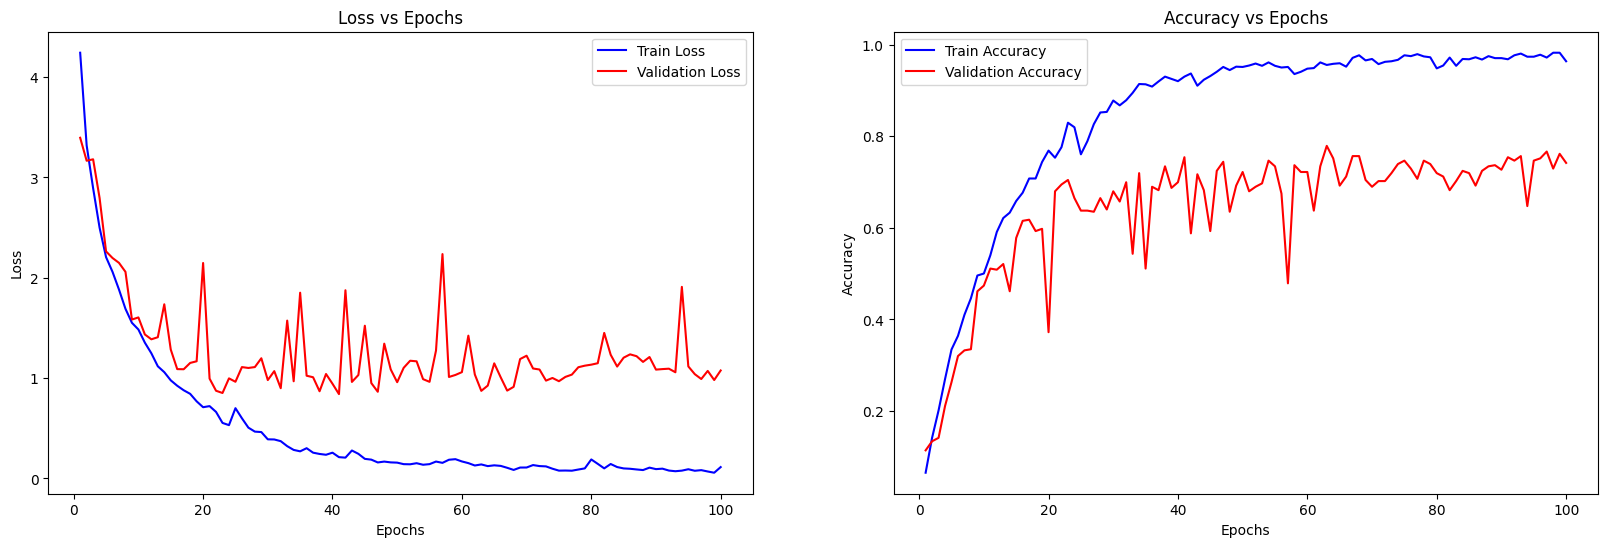

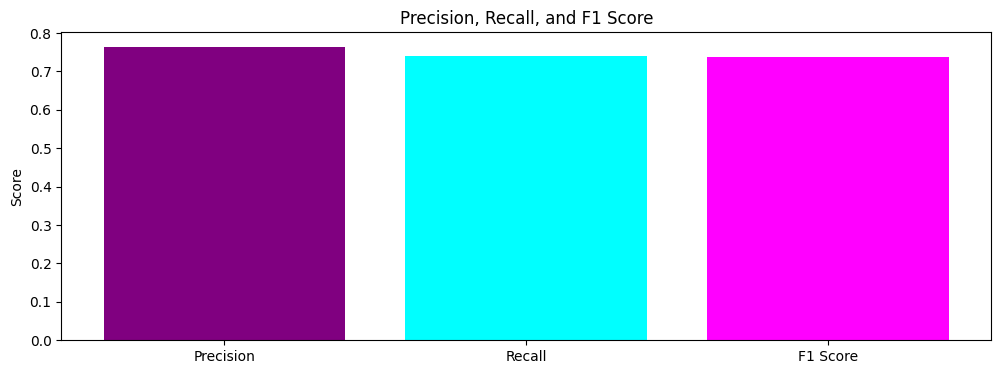

In [14]:
epochs = range(1, len(advanced_model_history.history['loss']) + 1)
train_loss = advanced_model_history.history['loss']
val_loss = advanced_model_history.history['val_loss']
train_accuracy = advanced_model_history.history['accuracy']
val_accuracy = advanced_model_history.history['val_accuracy']
plt.figure(figsize=(20, 6)) 
# Loss vs Epochs
plt.subplot(1,2, 1)
plt.plot(epochs, train_loss, label='Train Loss', color='blue')
plt.plot(epochs, val_loss, label='Validation Loss', color='red')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy vs Epochs
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, label='Train Accuracy', color='blue')
plt.plot(epochs, val_accuracy, label='Validation Accuracy', color='red')
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Plot Precision, Recall, and F1 Score
plt.figure(figsize=(12, 4))
plt.bar(['Precision', 'Recall', 'F1 Score'], 
        [metrics_adv_model['precision_advanced_model'], 
         metrics_adv_model['recall_advanced_model'], 
         metrics_adv_model['f1_score_advanced_model']],
        color=['purple', 'cyan', 'magenta'])
plt.title('Precision, Recall, and F1 Score')
plt.ylabel('Score')

plt.show()

In [15]:
def create_advanced_model_2(input_shape, num_classes):
    model = Sequential([
        Input(shape=input_shape),
        
        # First Convolutional Block
        Conv2D(256, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.5),
        
        
        # Second Convolutional Block
        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.5),
        
        # Third Convolutional Block
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.5),
        
        # Fourth Convolutional Block
        Conv2D(32, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.5),
        
        # Flatten and Fully Connected Layers
        Flatten(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

input_shape = (224, 224, 3)
num_classes = y_encoded.shape[1]
advanced_model_1 = create_advanced_model_2(input_shape, num_classes)

In [16]:
optimizer = Adam(learning_rate=0.001)

# Compile the model
advanced_model_1.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Fit the model
advanced_model_1_history = advanced_model_1.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=32)

# Evaluate the model on the test data
test_loss, test_accuracy = advanced_model_1.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Epoch 1/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 49s 487ms/step - accuracy: 0.0276 - loss: 4.8470 - val_accuracy: 0.0521 - val_loss: 8.8540
Epoch 2/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 0.0538 - loss: 4.2357 - val_accuracy: 0.1042 - val_loss: 3.9760
Epoch 3/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 0.1148 - loss: 3.4798 - val_accuracy: 0.1663 - val_loss: 2.6204
Epoch 4/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 0.1212 - loss: 3.1377 - val_accuracy: 0.1439 - val_loss: 3.0213
Epoch 5/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 0.1815 - loss: 2.8911 - val_accuracy: 0.0868 - val_loss: 3.4154
Epoch 6/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 0.2211 - loss: 2.6394 - val_accuracy: 0.0372 - val_loss: 4.9629
Epoch 7/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 0.3033 - loss: 2.3293 - val_accuracy: 0.0720 - val_loss: 4.0083
Epoch 8/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 0.3106 - loss: 2.2160 - val_acc

In [17]:
# Predict using the model
y_pred = np.argmax(advanced_model_1.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

# Calculate precision, recall, and F1 score
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Save all metrics in a dictionary with unique names
metrics_advanced_model_1 = {
    'test_loss_advanced_model_1': test_loss,
    'test_accuracy_advanced_model_1': test_accuracy,
    'val_loss_advanced_model_1': advanced_model_1_history.history['val_loss'][-1],
    'val_accuracy_advanced_model_1': advanced_model_1_history.history['val_accuracy'][-1],
    'precision_advanced_model_1': precision,
    'recall_advanced_model_1': recall,
    'f1_score_advanced_model_1': f1
}

print("Metrics saved for advanced model 1:", metrics_advanced_model_1)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step
Precision: 0.7312579536089867
Recall: 0.68389662027833
F1 Score: 0.6773596099188849
Metrics saved for advanced model 1: {'test_loss_advanced_model_1': 1.1512597799301147, 'test_accuracy_advanced_model_1': 0.6838966012001038, 'val_loss_advanced_model_1': 1.0405659675598145, 'val_accuracy_advanced_model_1': 0.6997518539428711, 'precision_advanced_model_1': 0.7312579536089867, 'recall_advanced_model_1': 0.68389662027833, 'f1_score_advanced_model_1': 0.6773596099188849}


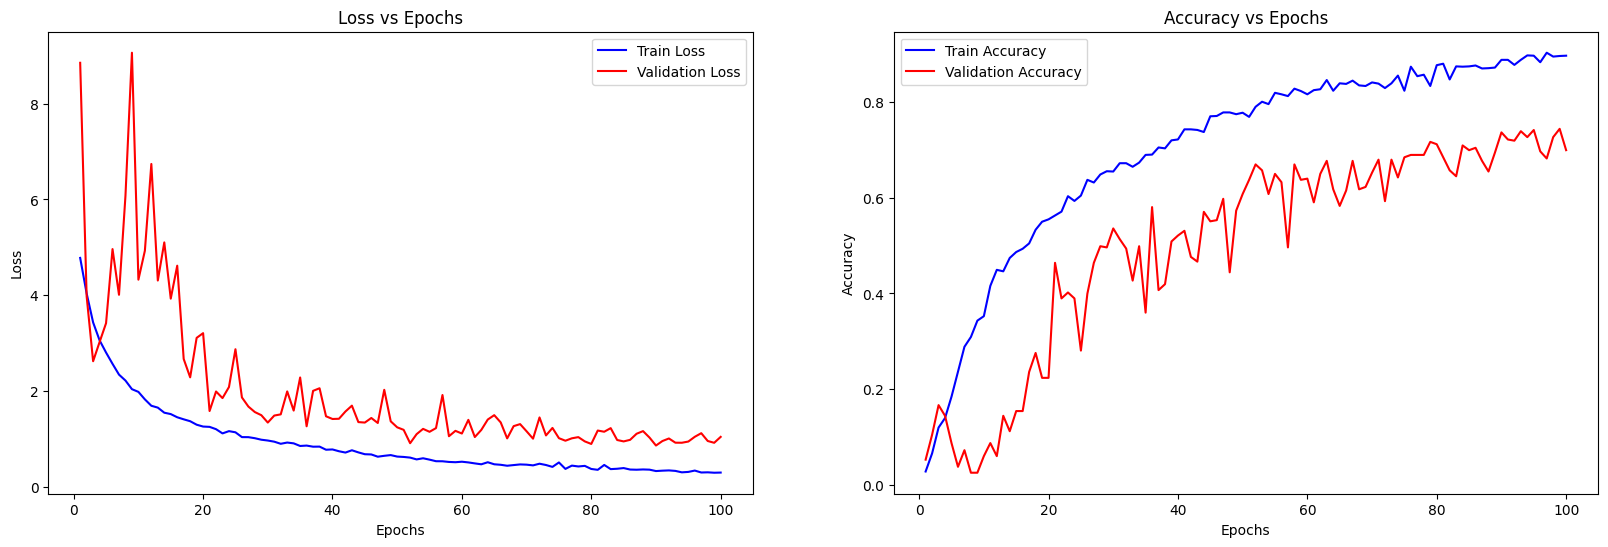

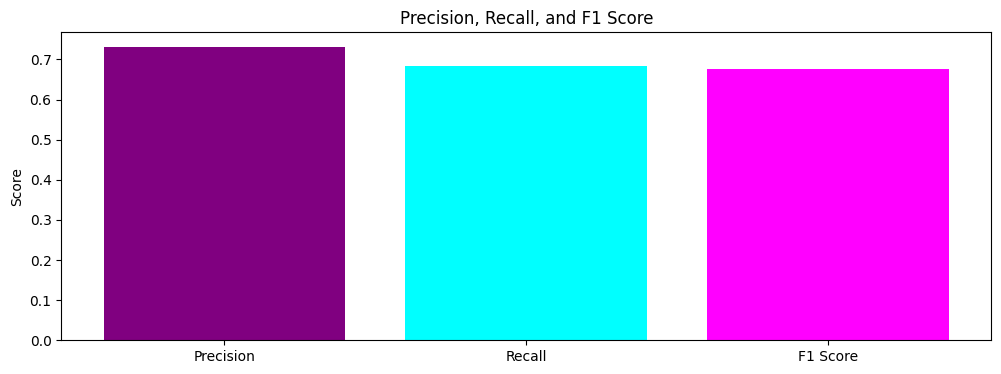

In [18]:
epochs = range(1, len(advanced_model_1_history.history['loss']) + 1)
train_loss = advanced_model_1_history.history['loss']
val_loss = advanced_model_1_history.history['val_loss']
train_accuracy = advanced_model_1_history.history['accuracy']
val_accuracy = advanced_model_1_history.history['val_accuracy']
plt.figure(figsize=(20, 6)) 
# Loss vs Epochs
plt.subplot(1,2, 1)
plt.plot(epochs, train_loss, label='Train Loss', color='blue')
plt.plot(epochs, val_loss, label='Validation Loss', color='red')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy vs Epochs
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, label='Train Accuracy', color='blue')
plt.plot(epochs, val_accuracy, label='Validation Accuracy', color='red')
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Plot Precision, Recall, and F1 Score
plt.figure(figsize=(12, 4))
plt.bar(['Precision', 'Recall', 'F1 Score'], 
        [metrics_advanced_model_1['precision_advanced_model_1'], 
         metrics_advanced_model_1['recall_advanced_model_1'], 
         metrics_advanced_model_1['f1_score_advanced_model_1']],
        color=['purple', 'cyan', 'magenta'])
plt.title('Precision, Recall, and F1 Score')
plt.ylabel('Score')

plt.show()

In [19]:
def create_advanced_model_3(input_shape, num_classes):
    model = Sequential([
        Input(shape=input_shape),
        
        # First Convolutional Block
        Conv2D(256, (7, 7), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.5),
        
        
        # Second Convolutional Block
        Conv2D(128, (7, 7), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.5),
        
        # Third Convolutional Block
        Conv2D(64, (7, 7), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.5),
        
        # Fourth Convolutional Block
        Conv2D(32, (7, 7), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.5),
        
        # Flatten and Fully Connected Layers
        Flatten(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

input_shape = (224, 224, 3)
num_classes = y_encoded.shape[1]
advanced_model_2 = create_advanced_model_3(input_shape, num_classes)

In [20]:
optimizer = Adam(learning_rate=0.001)

# Compile the model
advanced_model_2.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Fit the model
advanced_model_2_history = advanced_model_2.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=32)

# Evaluate the model on the test data
test_loss, test_accuracy = advanced_model_2.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Epoch 1/100


2024-09-09 05:05:11.072392: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[256,3,7,7]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,3,224,224]{3,2,1,0}, f32[32,256,218,218]{3,2,1,0}), window={size=7x7}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-09-09 05:05:12.292737: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 2.220478047s
Trying algorithm eng0{} for conv (f32[256,3,7,7]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,3,224,224]{3,2,1,0}, f32[32,256,218,218]{3,2,1,0}), window={size=7x7}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv

51/51 ━━━━━━━━━━━━━━━━━━━━ 72s 697ms/step - accuracy: 0.0268 - loss: 4.8351 - val_accuracy: 0.0323 - val_loss: 63.9019
Epoch 2/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 10s 187ms/step - accuracy: 0.0629 - loss: 4.1684 - val_accuracy: 0.0471 - val_loss: 16.1164
Epoch 3/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 10s 187ms/step - accuracy: 0.0955 - loss: 3.5736 - val_accuracy: 0.0893 - val_loss: 4.4007
Epoch 4/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 10s 187ms/step - accuracy: 0.1407 - loss: 3.2035 - val_accuracy: 0.2184 - val_loss: 2.5535
Epoch 5/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 10s 187ms/step - accuracy: 0.1591 - loss: 2.8995 - val_accuracy: 0.2705 - val_loss: 2.3368
Epoch 6/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 10s 186ms/step - accuracy: 0.1959 - loss: 2.7833 - val_accuracy: 0.3201 - val_loss: 2.1223
Epoch 7/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 10s 187ms/step - accuracy: 0.2546 - loss: 2.5366 - val_accuracy: 0.3077 - val_loss: 2.1583
Epoch 8/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 10s 187ms/step - accuracy: 0.2741 - loss: 2.3623 - val_accura

In [21]:
# Predict using the model
y_pred = np.argmax(advanced_model_2.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

# Calculate precision, recall, and F1 score
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Save all metrics in a dictionary with unique names
metrics_advanced_model_2 = {
    'test_loss_advanced_model_2': test_loss,
    'test_accuracy_advanced_model_2': test_accuracy,
    'val_loss_advanced_model_2': advanced_model_2_history.history['val_loss'][-1],
    'val_accuracy_advanced_model_2': advanced_model_2_history.history['val_accuracy'][-1],
    'precision_advanced_model_2': precision,
    'recall_advanced_model_2': recall,
    'f1_score_advanced_model_2': f1
}

print("Metrics saved for advanced model 2:", metrics_advanced_model_2)

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step
Precision: 0.7907777658545225
Recall: 0.7534791252485089
F1 Score: 0.754474118225478
Metrics saved for advanced model 2: {'test_loss_advanced_model_2': 0.7516552805900574, 'test_accuracy_advanced_model_2': 0.7534791231155396, 'val_loss_advanced_model_2': 0.6697900891304016, 'val_accuracy_advanced_model_2': 0.7816377282142639, 'precision_advanced_model_2': 0.7907777658545225, 'recall_advanced_model_2': 0.7534791252485089, 'f1_score_advanced_model_2': 0.754474118225478}


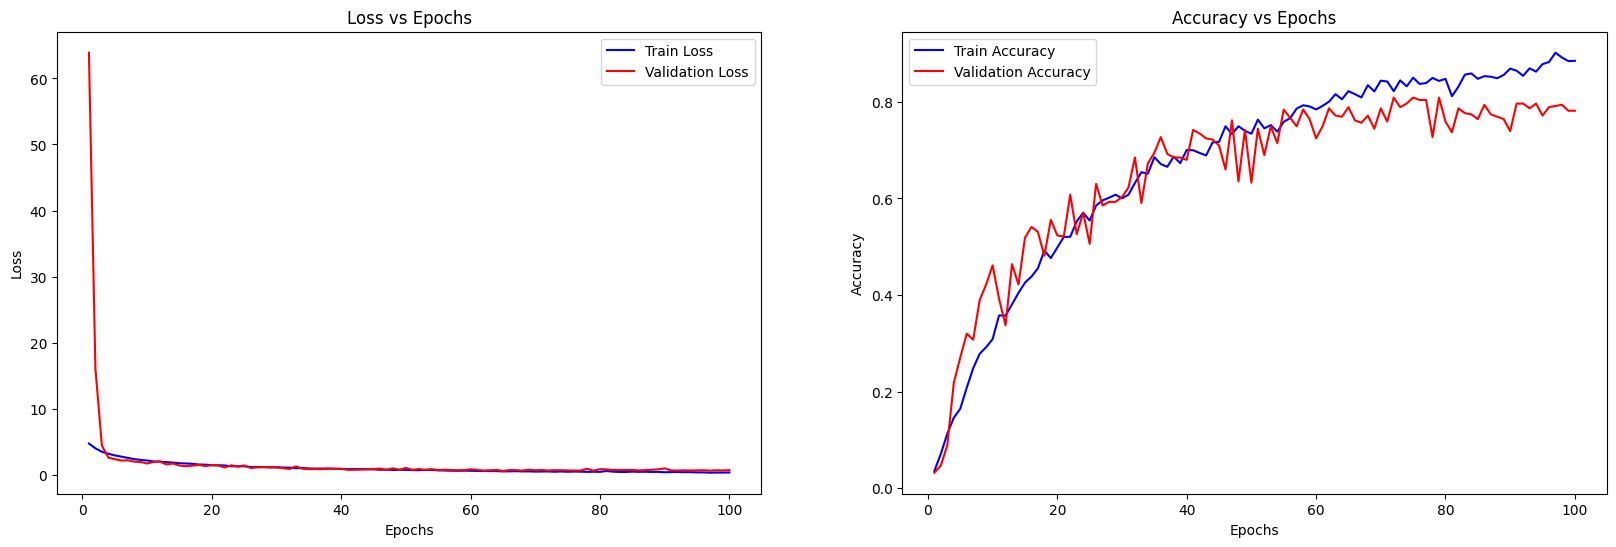

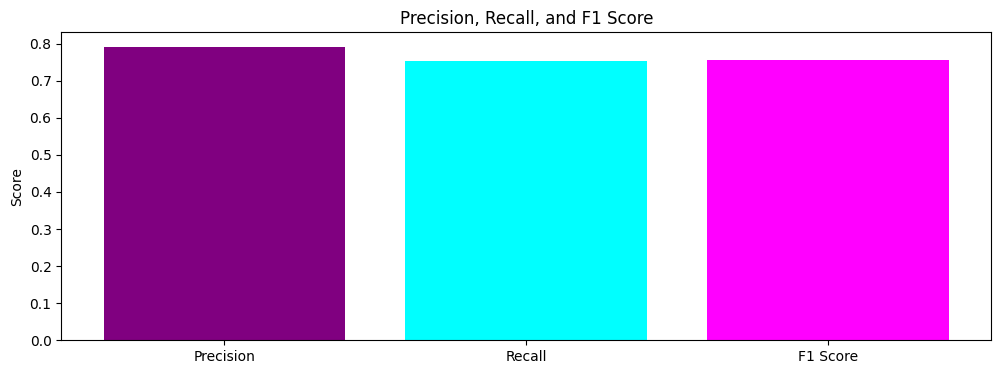

In [22]:
epochs = range(1, len(advanced_model_2_history.history['loss']) + 1)
train_loss = advanced_model_2_history.history['loss']
val_loss = advanced_model_2_history.history['val_loss']
train_accuracy = advanced_model_2_history.history['accuracy']
val_accuracy = advanced_model_2_history.history['val_accuracy']
plt.figure(figsize=(20, 6)) 
# Loss vs Epochs
plt.subplot(1,2, 1)
plt.plot(epochs, train_loss, label='Train Loss', color='blue')
plt.plot(epochs, val_loss, label='Validation Loss', color='red')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy vs Epochs
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, label='Train Accuracy', color='blue')
plt.plot(epochs, val_accuracy, label='Validation Accuracy', color='red')
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Plot Precision, Recall, and F1 Score
plt.figure(figsize=(12, 4))
plt.bar(['Precision', 'Recall', 'F1 Score'], 
        [metrics_advanced_model_2['precision_advanced_model_2'], 
         metrics_advanced_model_2['recall_advanced_model_2'], 
         metrics_advanced_model_2['f1_score_advanced_model_2']],
        color=['purple', 'cyan', 'magenta'])
plt.title('Precision, Recall, and F1 Score')
plt.ylabel('Score')

plt.show()

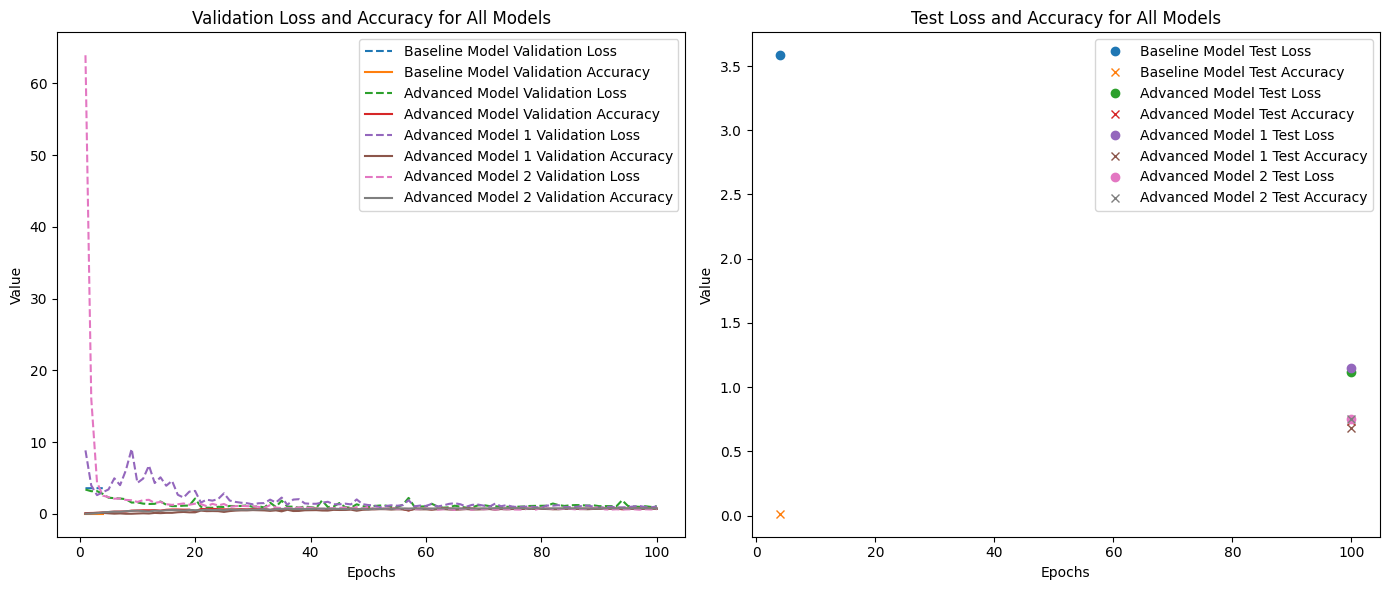

In [23]:
# Calculate test loss and accuracy for each model
test_loss_baseline, test_accuracy_baseline = baseline_model.evaluate(X_test, y_test, verbose=0)
test_loss_advanced, test_accuracy_advanced = advanced_model.evaluate(X_test, y_test, verbose=0)
test_loss_advanced_1, test_accuracy_advanced_1 = advanced_model_1.evaluate(X_test, y_test, verbose=0)
test_loss_advanced_2, test_accuracy_advanced_2 = advanced_model_2.evaluate(X_test, y_test, verbose=0)

# Store the history objects for each model
models = {
    "Baseline Model": baseline_history,
    "Advanced Model": advanced_model_history,
    "Advanced Model 1": advanced_model_1_history,
    "Advanced Model 2": advanced_model_2_history
}

# Store the test losses and accuracies
test_losses = {
    "Baseline Model": test_loss_baseline,
    "Advanced Model": test_loss_advanced,
    "Advanced Model 1": test_loss_advanced_1,
    "Advanced Model 2": test_loss_advanced_2
}

test_accuracies = {
    "Baseline Model": test_accuracy_baseline,
    "Advanced Model": test_accuracy_advanced,
    "Advanced Model 1": test_accuracy_advanced_1,
    "Advanced Model 2": test_accuracy_advanced_2
}

plt.figure(figsize=(14, 6))

# Plot validation loss and accuracy for all models in one graph
plt.subplot(1, 2, 1)
for model_name, history in models.items():
    epochs = range(1, len(history.history['loss']) + 1)
    val_loss = history.history['val_loss']
    val_accuracy = history.history['val_accuracy']
    plt.plot(epochs, val_loss, label=f'{model_name} Validation Loss', linestyle='--')
    plt.plot(epochs, val_accuracy, label=f'{model_name} Validation Accuracy')

plt.title('Validation Loss and Accuracy for All Models')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend(loc='best')

# Plot test loss and accuracy for all models in one graph
plt.subplot(1, 2, 2)
for model_name in models.keys():
    test_loss = test_losses[model_name]
    test_accuracy = test_accuracies[model_name]
    plt.plot([len(models[model_name].history['loss'])], [test_loss], 'o', label=f'{model_name} Test Loss')
    plt.plot([len(models[model_name].history['loss'])], [test_accuracy], 'x', label=f'{model_name} Test Accuracy')

plt.title('Test Loss and Accuracy for All Models')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend(loc='best')

plt.tight_layout()
plt.show()




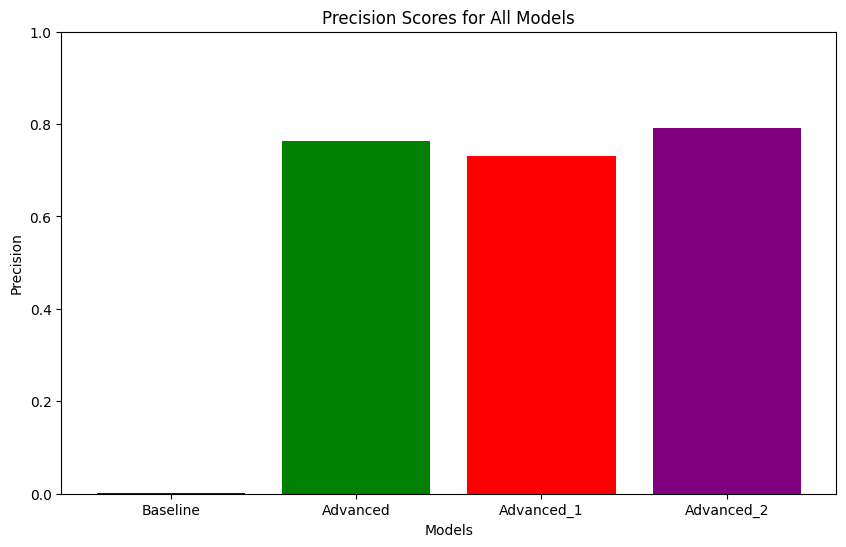

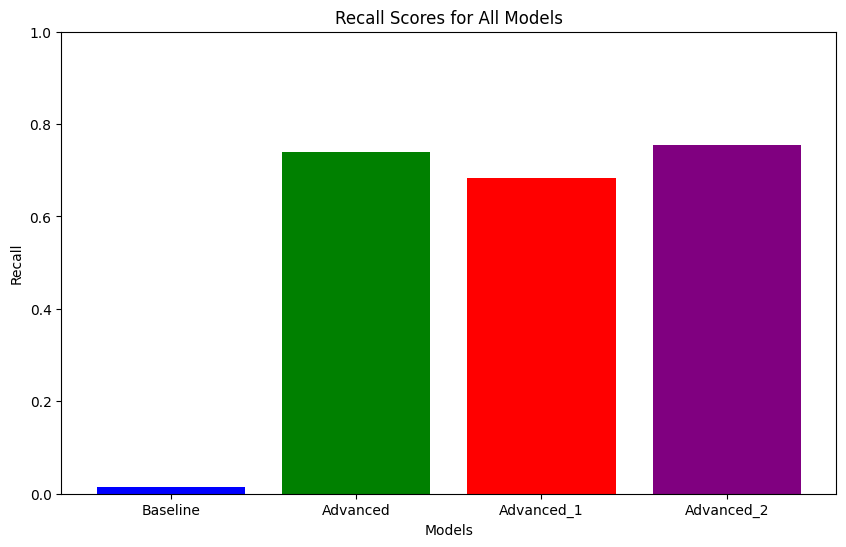

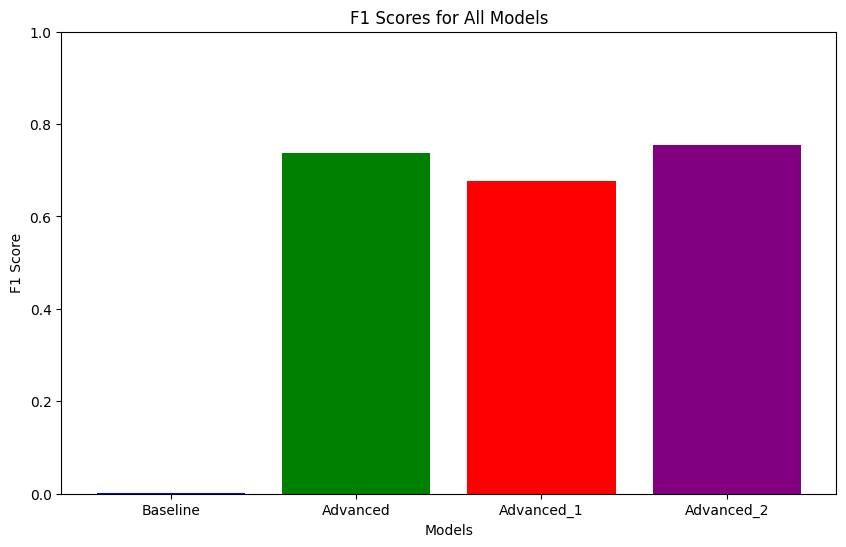

In [24]:
# Prepare data for all models
models = ['Baseline', 'Advanced', 'Advanced_1', 'Advanced_2']

precision_scores = [
    metrics_baseline['precision_baseline_model'], 
    metrics_adv_model['precision_advanced_model'], 
    metrics_advanced_model_1['precision_advanced_model_1'], 
    metrics_advanced_model_2['precision_advanced_model_2']
]

recall_scores = [
    metrics_baseline['recall_baseline_model'], 
    metrics_adv_model['recall_advanced_model'], 
    metrics_advanced_model_1['recall_advanced_model_1'], 
    metrics_advanced_model_2['recall_advanced_model_2']
]

f1_scores = [
    metrics_baseline['f1_score_baseline_model'], 
    metrics_adv_model['f1_score_advanced_model'], 
    metrics_advanced_model_1['f1_score_advanced_model_1'], 
    metrics_advanced_model_2['f1_score_advanced_model_2']
]

# Plot Precision for all models
plt.figure(figsize=(10, 6))
plt.bar(models, precision_scores, color=['blue', 'green', 'red', 'purple'])
plt.title('Precision Scores for All Models')
plt.ylabel('Precision')
plt.xlabel('Models')
plt.ylim(0, 1)  # Adjust if necessary
plt.show()

# Plot Recall for all models
plt.figure(figsize=(10, 6))
plt.bar(models, recall_scores, color=['blue', 'green', 'red', 'purple'])
plt.title('Recall Scores for All Models')
plt.ylabel('Recall')
plt.xlabel('Models')
plt.ylim(0, 1)  # Adjust if necessary
plt.show()

# Plot F1 Score for all models
plt.figure(figsize=(10, 6))
plt.bar(models, f1_scores, color=['blue', 'green', 'red', 'purple'])
plt.title('F1 Scores for All Models')
plt.ylabel('F1 Score')
plt.xlabel('Models')
plt.ylim(0, 1)  # Adjust if necessary
plt.show()


In [25]:
X = X / 255.0
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)  # 70% train, 30% temp
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)  # Split temp into 50% validation, 50% test

def data_generator(images, labels, batch_size, sequence_length):
    while True:
        for i in range(0, len(images), batch_size):
            batch_images = []
            batch_labels = []
            for j in range(i, i + batch_size):
                if j >= len(images):
                    break
                image_sequence = []
                for k in range(sequence_length):
                    image_sequence.append(images[j])  # For simplicity, using the same image for the sequence
                batch_images.append(image_sequence)
                batch_labels.append(labels[j])
            yield np.array(batch_images), np.array(batch_labels)


In [26]:
input_shape = (224, 224, 3)
sequence_length = 10

# Define the CNN-LSTM model
input_layer = Input(shape=(sequence_length, *input_shape))
x = TimeDistributed(Conv2D(32, (3, 3), activation='relu'))(input_layer)
x = TimeDistributed(MaxPooling2D((2, 2)))(x)
x = TimeDistributed(Conv2D(64, (3, 3), activation='relu'))(x)
x = TimeDistributed(MaxPooling2D((2, 2)))(x)
x = TimeDistributed(Flatten())(x)
x = LSTM(128, return_sequences=False)(x)
output_layer = Dense(len(set(y)), activation='softmax')(x)  # Assuming y contains the labels

cnn_lstm_model = Model(inputs=input_layer, outputs=output_layer)
cnn_lstm_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
cnn_lstm_model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 10, 224, 224,   │             0 │
│                                 │ 3)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 10, 222, 222,   │           896 │
│ (TimeDistributed)               │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 10, 111, 111,   │             0 │
│ (TimeDistributed)               │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 10, 109, 109,   │        18,496 │
│ (TimeDistributed)               │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 10, 54, 54, 64) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 10, 186624)     │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │    95,617,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 36)             │         4,644 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 95,641,572 (364.84 MB)

 Trainable params: 95,641,572 (364.84 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
batch_size = 8
patience = 5
train_gen = data_generator(X_train, y_train, batch_size, sequence_length)
val_gen = data_generator(X_val, y_val, batch_size, sequence_length)
test_gen = data_generator(X_test, y_test, batch_size, sequence_length)

# Calculate steps per epoch and validation steps
steps_per_epoch = len(X_train) // batch_size
validation_steps = len(X_val) // batch_size

# Initialize callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

# Train the model
history_cnn_lstm = cnn_lstm_model.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=100,
    validation_data=val_gen,
    validation_steps=validation_steps,
    callbacks=[early_stopping]
)

# Evaluate on test data
test_loss, test_accuracy = cnn_lstm_model.evaluate(test_gen, steps=len(X_test) // batch_size)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

Epoch 1/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 54s 228ms/step - accuracy: 0.0862 - loss: 3.4840 - val_accuracy: 0.1170 - val_loss: 3.0769
Epoch 2/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 49s 223ms/step - accuracy: 0.2370 - loss: 2.8092 - val_accuracy: 0.2656 - val_loss: 2.6498
Epoch 3/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 49s 223ms/step - accuracy: 0.4669 - loss: 2.2529 - val_accuracy: 0.3794 - val_loss: 2.2077
Epoch 4/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 49s 222ms/step - accuracy: 0.6271 - loss: 1.7013 - val_accuracy: 0.4499 - val_loss: 1.9089
Epoch 5/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 49s 223ms/step - accuracy: 0.7804 - loss: 1.1767 - val_accuracy: 0.4634 - val_loss: 1.7149
Epoch 6/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 49s 223ms/step - accuracy: 0.9003 - loss: 0.7683 - val_accuracy: 0.5230 - val_loss: 1.5871
Epoch 7/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 49s 223ms/step - accuracy: 0.9627 - loss: 0.4245 - val_accuracy: 0.5339 - val_loss: 1.5209
Epoch 8/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 49s 223ms/step - accuracy: 0.9809 -

In [28]:
y_val_pred = np.argmax(cnn_lstm_model.predict(val_gen, steps=validation_steps), axis=1)
y_val_true = y_val[:len(y_val_pred)]  # Ensure y_val_true matches the length of y_val_pred

# Calculate precision, recall, and F1 score
precision = precision_score(y_val_true, y_val_pred, average='weighted')
recall = recall_score(y_val_true, y_val_pred, average='weighted')
f1 = f1_score(y_val_true, y_val_pred, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Save all metrics in a dictionary with unique names
metrics_cnn_lstm_model = {
    'test_loss_cnn_lstm': test_loss,
    'test_accuracy_cnn_lstm': test_accuracy,
    'val_loss_cnn_lstm': history_cnn_lstm.history['val_loss'][-1],  # Assuming val_loss is in history
    'val_accuracy_cnn_lstm': history_cnn_lstm.history['val_accuracy'][-1],  # Assuming val_accuracy is in history
    'precision_cnn_lstm': precision,
    'recall_cnn_lstm': recall,
    'f1_score_cnn_lstm': f1
}

print("Metrics saved for CNN-LSTM model:", metrics_cnn_lstm_model)

47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 121ms/step
Precision: 0.023758017446506963
Recall: 0.024390243902439025
F1 Score: 0.022929111675843362
Metrics saved for CNN-LSTM model: {'test_loss_cnn_lstm': 1.3313695192337036, 'test_accuracy_cnn_lstm': 0.5797872543334961, 'val_loss_cnn_lstm': 1.4232144355773926, 'val_accuracy_cnn_lstm': 0.5718157291412354, 'precision_cnn_lstm': 0.023758017446506963, 'recall_cnn_lstm': 0.024390243902439025, 'f1_score_cnn_lstm': 0.022929111675843362}


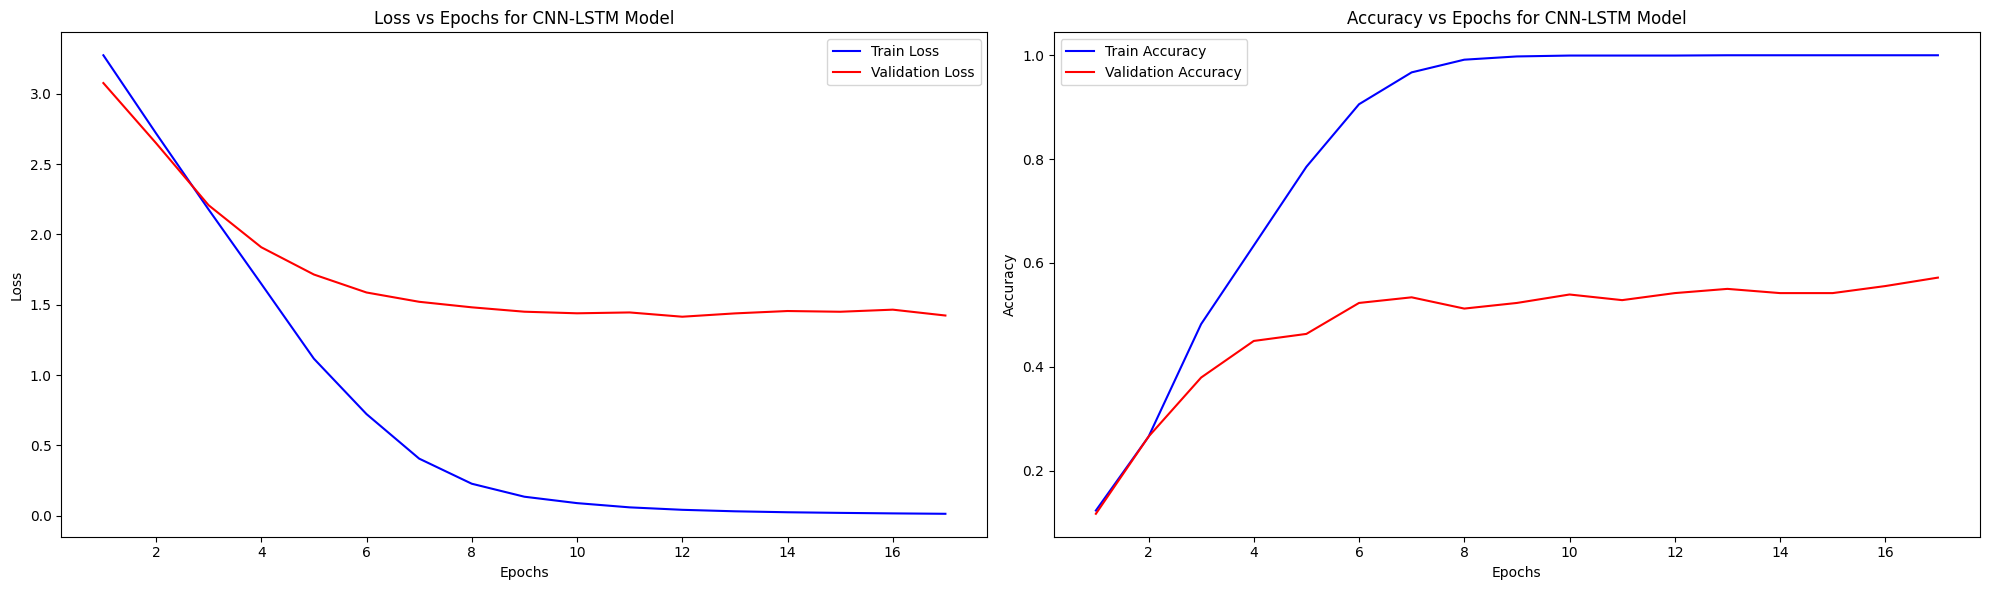

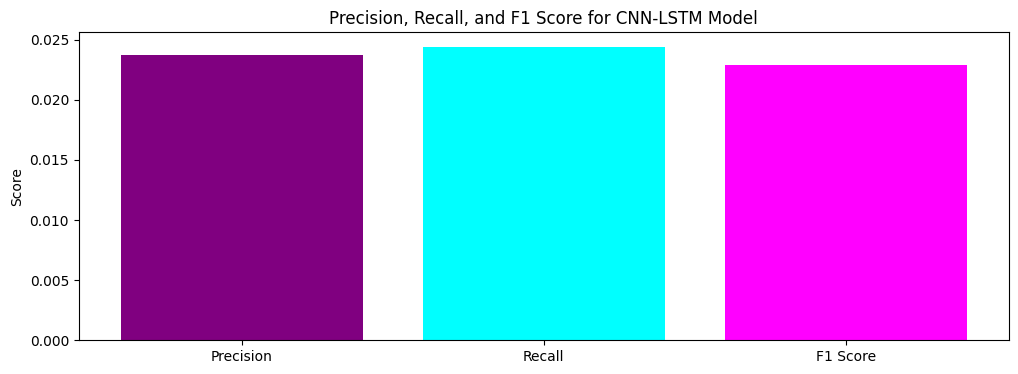

In [29]:
# Assuming 'history' is the History object returned from model.fit() for CNN-LSTM
epochs = range(1, len(history_cnn_lstm.history['loss']) + 1)
train_loss = history_cnn_lstm.history['loss']
val_loss = history_cnn_lstm.history['val_loss']
train_accuracy = history_cnn_lstm.history['accuracy']
val_accuracy = history_cnn_lstm.history['val_accuracy']

# Plot Loss and Accuracy vs Epochs
plt.figure(figsize=(20, 6)) 

# Loss vs Epochs
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Train Loss', color='blue')
plt.plot(epochs, val_loss, label='Validation Loss', color='red')
plt.title('Loss vs Epochs for CNN-LSTM Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy vs Epochs
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, label='Train Accuracy', color='blue')
plt.plot(epochs, val_accuracy, label='Validation Accuracy', color='red')
plt.title('Accuracy vs Epochs for CNN-LSTM Model')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Plot Precision, Recall, and F1 Score
plt.figure(figsize=(12, 4))
plt.bar(['Precision', 'Recall', 'F1 Score'], 
        [metrics_cnn_lstm_model['precision_cnn_lstm'], 
         metrics_cnn_lstm_model['recall_cnn_lstm'], 
         metrics_cnn_lstm_model['f1_score_cnn_lstm']],
        color=['purple', 'cyan', 'magenta'])
plt.title('Precision, Recall, and F1 Score for CNN-LSTM Model')
plt.ylabel('Score')

plt.show()

In [30]:
# Define input shape and sequence length
input_shape = (224, 224, 3)
sequence_length = 10  # Example sequence length

# Pretrained model for feature extraction
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

# Define the CNN-LSTM model
input_layer = Input(shape=(sequence_length, *input_shape))

# Process each frame in the sequence
def process_frame(x):
    features = []
    for i in range(sequence_length):
        frame = x[:, i, :, :, :]
        feature = base_model(frame)
        feature = Flatten()(feature)
        features.append(feature)
    return tf.stack(features, axis=1)

x = Lambda(process_frame)(input_layer)
x = LSTM(256, return_sequences=False)(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
output_layer = Dense(len(set(y_train)), activation='softmax')(x)  # Assuming the number of classes is len(set(y_train))
cnn_lstm_resnet_model = Model(inputs=input_layer, outputs=output_layer)
cnn_lstm_resnet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# Print the model summary
cnn_lstm_resnet_model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 10, 224, 224,   │             0 │
│                                 │ 3)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 10, 100352)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 256)            │   103,023,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 36)             │         9,252 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 103,033,892 (393.04 MB)

 Trainable params: 103,033,380 (393.04 MB)

 Non-trainable params: 512 (2.00 KB)

In [31]:
# Create the data generators (Assume data_generator is defined)
batch_size = 16
patience =5
train_gen = data_generator(X_train, y_train, batch_size, sequence_length)
val_gen = data_generator(X_val, y_val, batch_size, sequence_length)

# Calculate steps per epoch and validation steps
steps_per_epoch = len(X_train) // batch_size
validation_steps = len(X_val) // batch_size
early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
# Train the model
history_cnn_lstm_resnet = cnn_lstm_resnet_model.fit(train_gen,
                                                    steps_per_epoch=steps_per_epoch, 
                                                    epochs=100, validation_data=val_gen, 
                                                    validation_steps=validation_steps,
                                                    callbacks=[early_stopping])

test_loss, test_accuracy = cnn_lstm_resnet_model.evaluate(test_gen, steps=len(X_test) // batch_size)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

Epoch 1/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 208s 893ms/step - accuracy: 0.2144 - loss: 3.4219 - val_accuracy: 0.3125 - val_loss: 2.6559
Epoch 2/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 80s 732ms/step - accuracy: 0.7166 - loss: 1.1484 - val_accuracy: 0.7202 - val_loss: 1.2146
Epoch 3/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 80s 728ms/step - accuracy: 0.8767 - loss: 0.5778 - val_accuracy: 0.7590 - val_loss: 0.8838
Epoch 4/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 80s 727ms/step - accuracy: 0.9386 - loss: 0.3265 - val_accuracy: 0.8255 - val_loss: 0.6753
Epoch 5/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 80s 729ms/step - accuracy: 0.9724 - loss: 0.1947 - val_accuracy: 0.8172 - val_loss: 0.6300
Epoch 6/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 80s 728ms/step - accuracy: 0.9861 - loss: 0.1271 - val_accuracy: 0.8338 - val_loss: 0.5813
Epoch 7/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 80s 729ms/step - accuracy: 0.9951 - loss: 0.0812 - val_accuracy: 0.8393 - val_loss: 0.5431
Epoch 8/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 80s 727ms/step - accuracy: 0.9987 

In [32]:
y_val_pred_probs = cnn_lstm_resnet_model.predict(val_gen, steps=validation_steps)
y_val_pred = np.argmax(y_val_pred_probs, axis=1)
y_val_true = np.array(y_val[:len(y_val_pred)])  # Ensure y_val_true matches the length of y_val_pred

# Calculate precision, recall, and F1 score
precision = precision_score(y_val_true, y_val_pred, average='weighted')
recall = recall_score(y_val_true, y_val_pred, average='weighted')
f1 = f1_score(y_val_true, y_val_pred, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Save all metrics in a dictionary with unique names
metrics_cnn_lstm_resnet = {
    'test_loss_cnn_lstm_resnet': test_loss,
    'test_accuracy_cnn_lstm_resnet': test_accuracy,
    'val_loss_cnn_lstm_resnet': history_cnn_lstm_resnet.history['val_loss'][-1],  # Get last value of val_loss
    'val_accuracy_cnn_lstm_resnet': history_cnn_lstm_resnet.history['val_accuracy'][-1],  # Get last value of val_accuracy
    'precision_cnn_lstm_resnet': precision,
    'recall_cnn_lstm_resnet': recall,
    'f1_score_cnn_lstm_resnet': f1
}

print("Metrics saved for CNN-LSTM-ResNet model:", metrics_cnn_lstm_resnet)

23/23 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step
Precision: 0.03626209893522913
Recall: 0.0332409972299169
F1 Score: 0.03433558798656314
Metrics saved for CNN-LSTM-ResNet model: {'test_loss_cnn_lstm_resnet': 0.43800291419029236, 'test_accuracy_cnn_lstm_resnet': 0.885869562625885, 'val_loss_cnn_lstm_resnet': 0.4724302291870117, 'val_accuracy_cnn_lstm_resnet': 0.8587257862091064, 'precision_cnn_lstm_resnet': 0.03626209893522913, 'recall_cnn_lstm_resnet': 0.0332409972299169, 'f1_score_cnn_lstm_resnet': 0.03433558798656314}


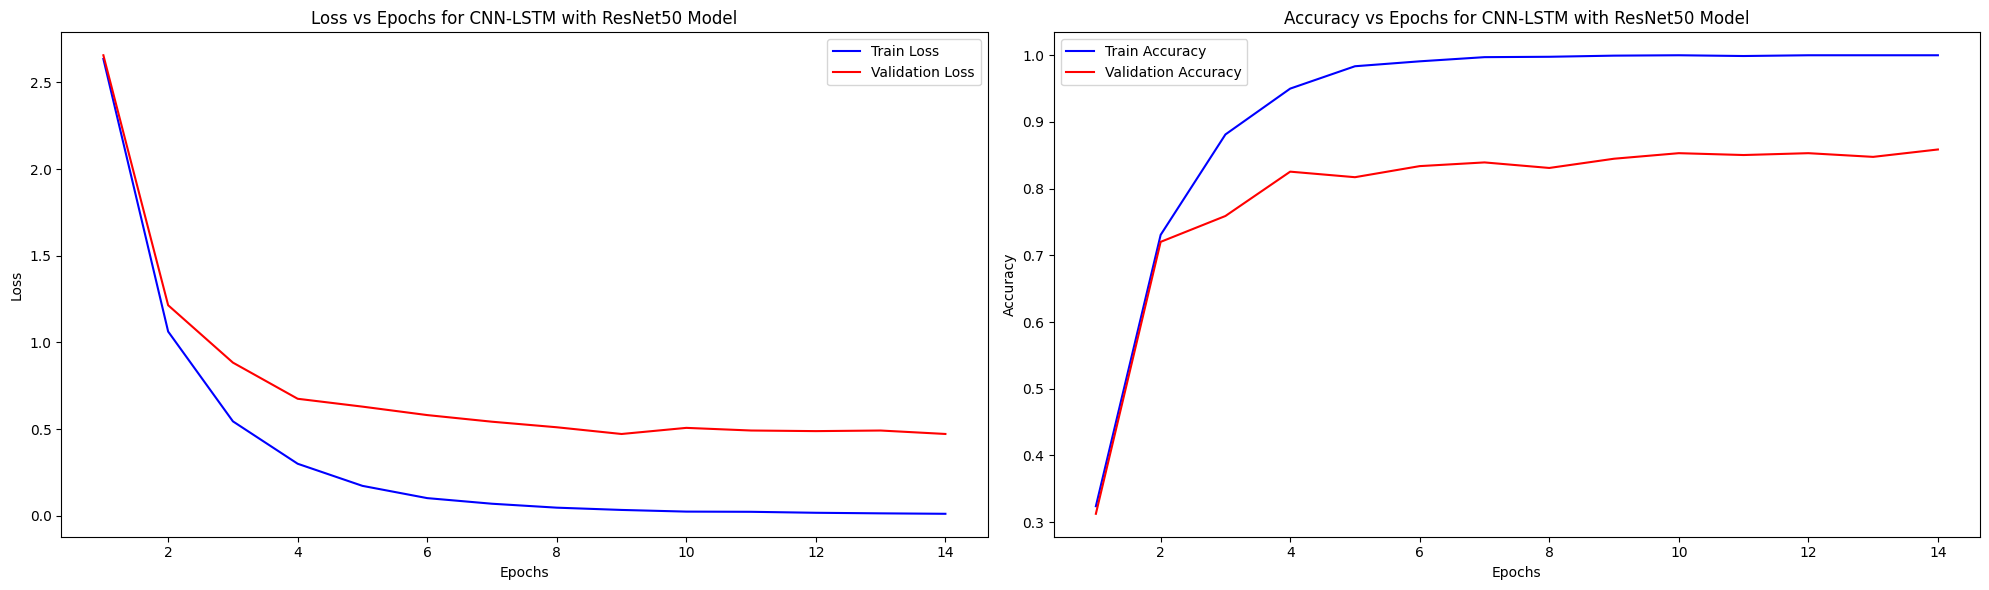

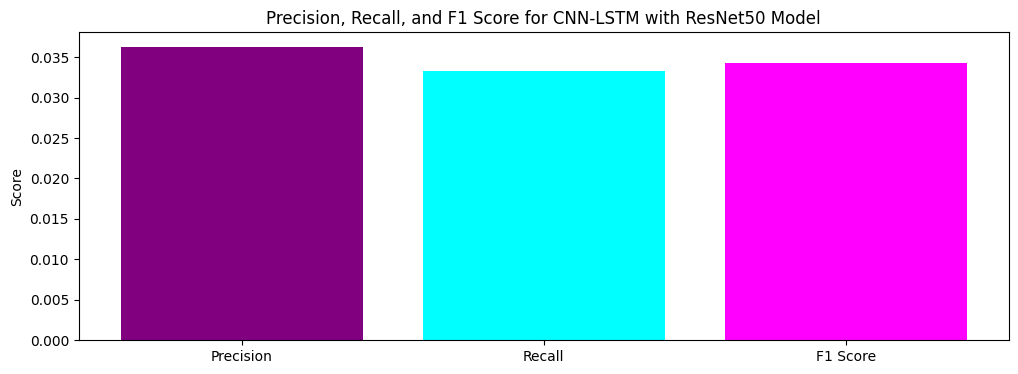

In [33]:
# Assuming 'history' is the History object retI’m urned from model.fit() for CNN-LSTM with ResNet50
epochs = range(1, len(history_cnn_lstm_resnet.history['loss']) + 1)
train_loss = history_cnn_lstm_resnet.history['loss']
val_loss = history_cnn_lstm_resnet.history['val_loss']
train_accuracy = history_cnn_lstm_resnet.history['accuracy']
val_accuracy = history_cnn_lstm_resnet.history['val_accuracy']

# Plot Loss and Accuracy vs Epochs
plt.figure(figsize=(20, 6))

# Loss vs Epochs
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Train Loss', color='blue')
plt.plot(epochs, val_loss, label='Validation Loss', color='red')
plt.title('Loss vs Epochs for CNN-LSTM with ResNet50 Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy vs Epochs
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, label='Train Accuracy', color='blue')
plt.plot(epochs, val_accuracy, label='Validation Accuracy', color='red')
plt.title('Accuracy vs Epochs for CNN-LSTM with ResNet50 Model')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Plot Precision, Recall, and F1 Score
plt.figure(figsize=(12, 4))
plt.bar(['Precision', 'Recall', 'F1 Score'], 
        [metrics_cnn_lstm_resnet['precision_cnn_lstm_resnet'], 
         metrics_cnn_lstm_resnet['recall_cnn_lstm_resnet'], 
         metrics_cnn_lstm_resnet['f1_score_cnn_lstm_resnet']],
        color=['purple', 'cyan', 'magenta'])
plt.title('Precision, Recall, and F1 Score for CNN-LSTM with ResNet50 Model')
plt.ylabel('Score')

plt.show()

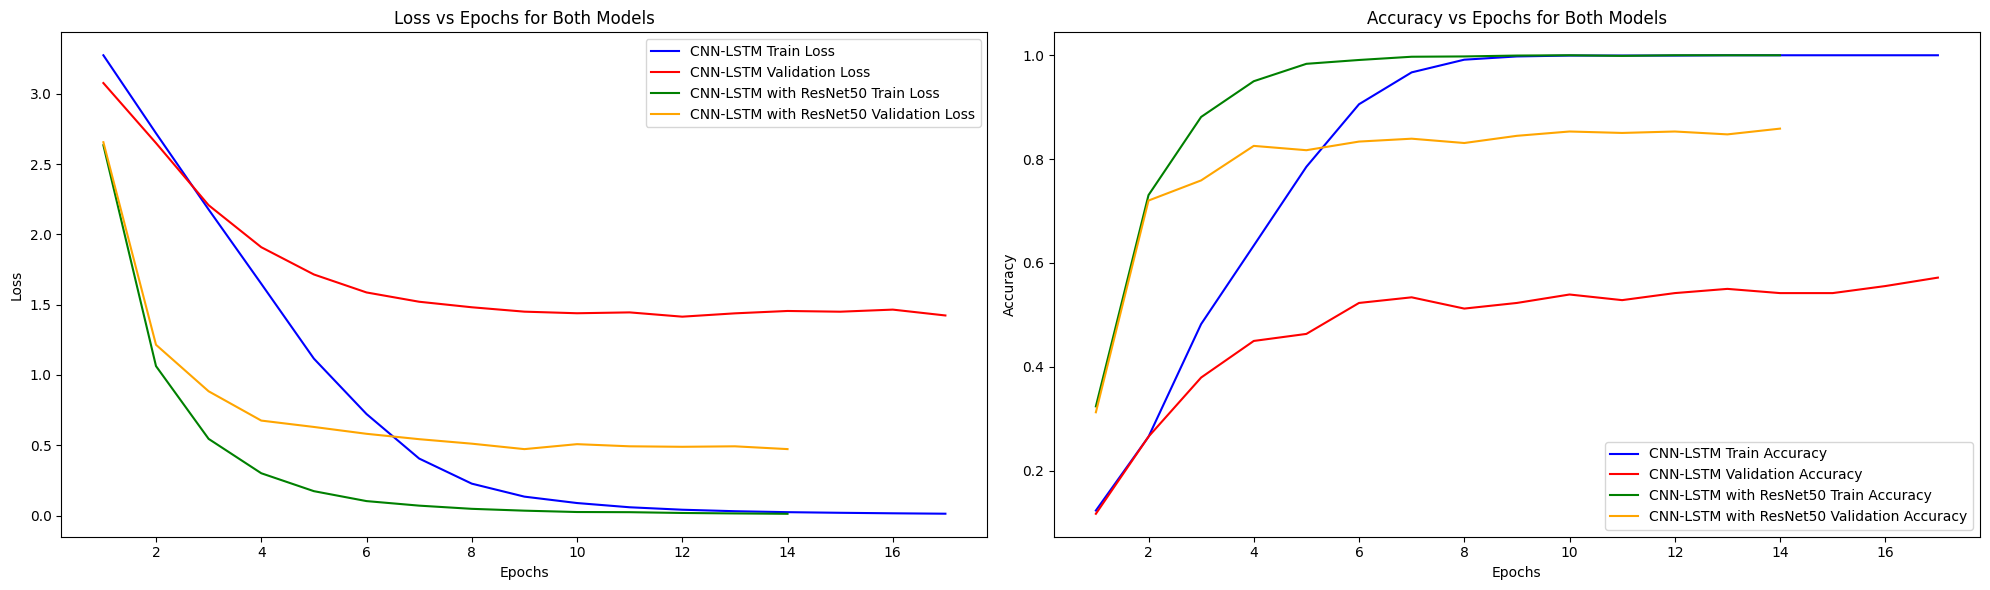

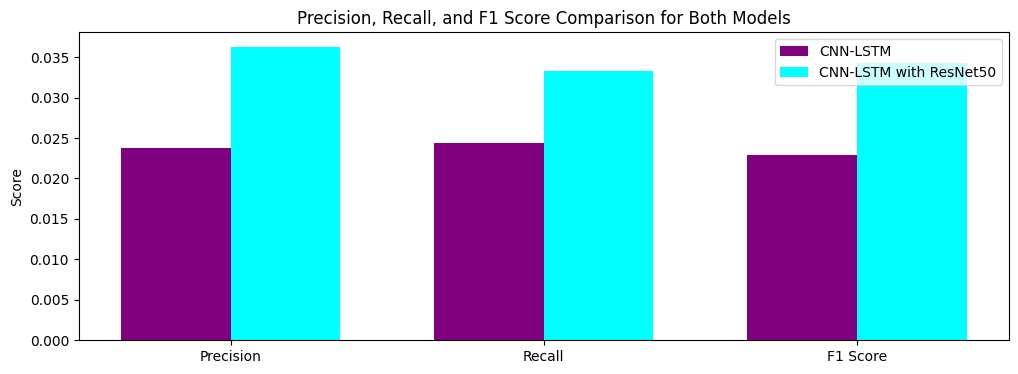

In [34]:
# Metrics from CNN-LSTM model training
epochs_cnn_lstm = range(1, len(history_cnn_lstm.history['loss']) + 1)
train_loss_cnn_lstm = history_cnn_lstm.history['loss']
val_loss_cnn_lstm = history_cnn_lstm.history['val_loss']
train_accuracy_cnn_lstm = history_cnn_lstm.history['accuracy']
val_accuracy_cnn_lstm = history_cnn_lstm.history['val_accuracy']

# Metrics from CNN-LSTM with ResNet50 model training
epochs_cnn_lstm_resnet = range(1, len(history_cnn_lstm_resnet.history['loss']) + 1)
train_loss_cnn_lstm_resnet = history_cnn_lstm_resnet.history['loss']
val_loss_cnn_lstm_resnet = history_cnn_lstm_resnet.history['val_loss']
train_accuracy_cnn_lstm_resnet = history_cnn_lstm_resnet.history['accuracy']
val_accuracy_cnn_lstm_resnet = history_cnn_lstm_resnet.history['val_accuracy']

# Plot Loss and Accuracy for both models
plt.figure(figsize=(20, 6))

# Loss vs Epochs
plt.subplot(1, 2, 1)
plt.plot(epochs_cnn_lstm, train_loss_cnn_lstm, label='CNN-LSTM Train Loss', color='blue')
plt.plot(epochs_cnn_lstm, val_loss_cnn_lstm, label='CNN-LSTM Validation Loss', color='red')
plt.plot(epochs_cnn_lstm_resnet, train_loss_cnn_lstm_resnet, label='CNN-LSTM with ResNet50 Train Loss', color='green')
plt.plot(epochs_cnn_lstm_resnet, val_loss_cnn_lstm_resnet, label='CNN-LSTM with ResNet50 Validation Loss', color='orange')
plt.title('Loss vs Epochs for Both Models')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy vs Epochs
plt.subplot(1, 2, 2)
plt.plot(epochs_cnn_lstm, train_accuracy_cnn_lstm, label='CNN-LSTM Train Accuracy', color='blue')
plt.plot(epochs_cnn_lstm, val_accuracy_cnn_lstm, label='CNN-LSTM Validation Accuracy', color='red')
plt.plot(epochs_cnn_lstm_resnet, train_accuracy_cnn_lstm_resnet, label='CNN-LSTM with ResNet50 Train Accuracy', color='green')
plt.plot(epochs_cnn_lstm_resnet, val_accuracy_cnn_lstm_resnet, label='CNN-LSTM with ResNet50 Validation Accuracy', color='orange')
plt.title('Accuracy vs Epochs for Both Models')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Plot Precision, Recall, and F1 Score for both models
plt.figure(figsize=(12, 4))

# Define metrics for both models
metrics_cnn_lstm = [metrics_cnn_lstm_model['precision_cnn_lstm'], 
                    metrics_cnn_lstm_model['recall_cnn_lstm'], 
                    metrics_cnn_lstm_model['f1_score_cnn_lstm']]

metrics_cnn_lstm_resnet = [metrics_cnn_lstm_resnet['precision_cnn_lstm_resnet'], 
                           metrics_cnn_lstm_resnet['recall_cnn_lstm_resnet'], 
                           metrics_cnn_lstm_resnet['f1_score_cnn_lstm_resnet']]

bar_width = 0.35
index = range(len(metrics_cnn_lstm))

# Plot bar chart for Precision, Recall, and F1 Score
plt.bar(index, metrics_cnn_lstm, bar_width, label='CNN-LSTM', color='purple')
plt.bar([i + bar_width for i in index], metrics_cnn_lstm_resnet, bar_width, label='CNN-LSTM with ResNet50', color='cyan')

plt.xticks([i + bar_width / 2 for i in index], ['Precision', 'Recall', 'F1 Score'])
plt.title('Precision, Recall, and F1 Score Comparison for Both Models')
plt.ylabel('Score')
plt.legend()

plt.show()


In [35]:
def create_vit_model(input_shape, num_classes, patch_size=16, projection_dim=64, num_heads=8, transformer_units=[128, 64], mlp_head_units=[128, 64]):
    # Calculate number of patches
    num_patches = (input_shape[0] // patch_size) * (input_shape[1] // patch_size)
    
    inputs = keras.Input(shape=input_shape)
    
    # Create patches
    patches = layers.Conv2D(filters=projection_dim, kernel_size=patch_size, strides=patch_size, padding='valid')(inputs)
    patches = layers.Reshape((num_patches, projection_dim))(patches)
    
    # Add positional embedding
    positions = tf.range(start=0, limit=num_patches, delta=1)
    positional_embedding = layers.Embedding(input_dim=num_patches, output_dim=projection_dim)(positions)
    encoded_patches = patches + positional_embedding
    
    # Transformer layers
    for unit in transformer_units:
        # Layer normalization 1
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Multi-head attention layer
        attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim, dropout=0.1)(x1, x1)
        # Skip connection 1
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP
        x3 = layers.Dense(unit, activation='relu')(x3)
        x3 = layers.Dense(projection_dim)(x3)
        # Skip connection 2
        encoded_patches = layers.Add()([x3, x2])
    
    # Apply global average pooling
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dense(mlp_head_units[0], activation='relu')(representation)
    representation = layers.Dropout(0.5)(representation)
    representation = layers.Dense(mlp_head_units[1], activation='relu')(representation)
    
    # Output layer
    logits = layers.Dense(num_classes)(representation)
    
    return keras.Model(inputs=inputs, outputs=logits)

# Parameters for the model
input_shape = (224, 224, 3)  # Adjust based on your preprocessed image dimensions
num_classes = 36  # Number of ASL classes
vit_model = create_vit_model(input_shape, num_classes)
vit_model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4),
                  loss=keras.losses.CategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])


In [36]:
# Convert labels to one-hot encoded format (2D array)
y_train = keras.utils.to_categorical(y_train, num_classes=num_classes)  # Ensure num_classes is correct
y_val = keras.utils.to_categorical(y_val, num_classes=num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes=num_classes)

# Fit the model with corrected data
vit_model_history = vit_model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=20)

# Evaluate the model on the validation set
val_loss, val_accuracy = vit_model.evaluate(X_val, y_val)
print(f"Validation accuracy: {val_accuracy}")

# Evaluate the model on the test set
test_loss, test_accuracy = vit_model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Epoch 1/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 17s 76ms/step - accuracy: 0.0242 - loss: 3.7729 - val_accuracy: 0.0292 - val_loss: 3.5770
Epoch 2/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.0343 - loss: 3.5730 - val_accuracy: 0.0398 - val_loss: 3.5755
Epoch 3/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.0294 - loss: 3.5741 - val_accuracy: 0.0159 - val_loss: 3.5697
Epoch 4/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.0168 - loss: 3.5664 - val_accuracy: 0.0477 - val_loss: 3.5449
Epoch 5/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.0409 - loss: 3.5315 - val_accuracy: 0.0637 - val_loss: 3.5033
Epoch 6/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.0623 - loss: 3.4878 - val_accuracy: 0.0663 - val_loss: 3.4488
Epoch 7/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.0591 - loss: 3.4048 - val_accuracy: 0.0822 - val_loss: 3.2912
Epoch 8/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.0763 - loss: 3.3050 - val_accuracy: 0.0796 - 

In [37]:
# Predict on the validation set
y_val_pred_probs = vit_model.predict(X_val)
y_val_pred = np.argmax(y_val_pred_probs, axis=1)
y_val_true = np.argmax(y_val, axis=1)  # Convert one-hot encoded labels to class labels

# Calculate precision, recall, and F1 score
precision = precision_score(y_val_true, y_val_pred, average='weighted')
recall = recall_score(y_val_true, y_val_pred, average='weighted')
f1 = f1_score(y_val_true, y_val_pred, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Save all metrics in a dictionary
metrics_vit = {
    'test_loss_vit': test_loss,
    'test_accuracy_vit': test_accuracy,
    'val_loss_vit': val_loss,
    'val_accuracy_vit': val_accuracy,
    'precision_vit': precision,
    'recall_vit': recall,
    'f1_score_vit': f1
}


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step
Precision: 0.30909790327701886
Recall: 0.2493368700265252
F1 Score: 0.2322827729591879


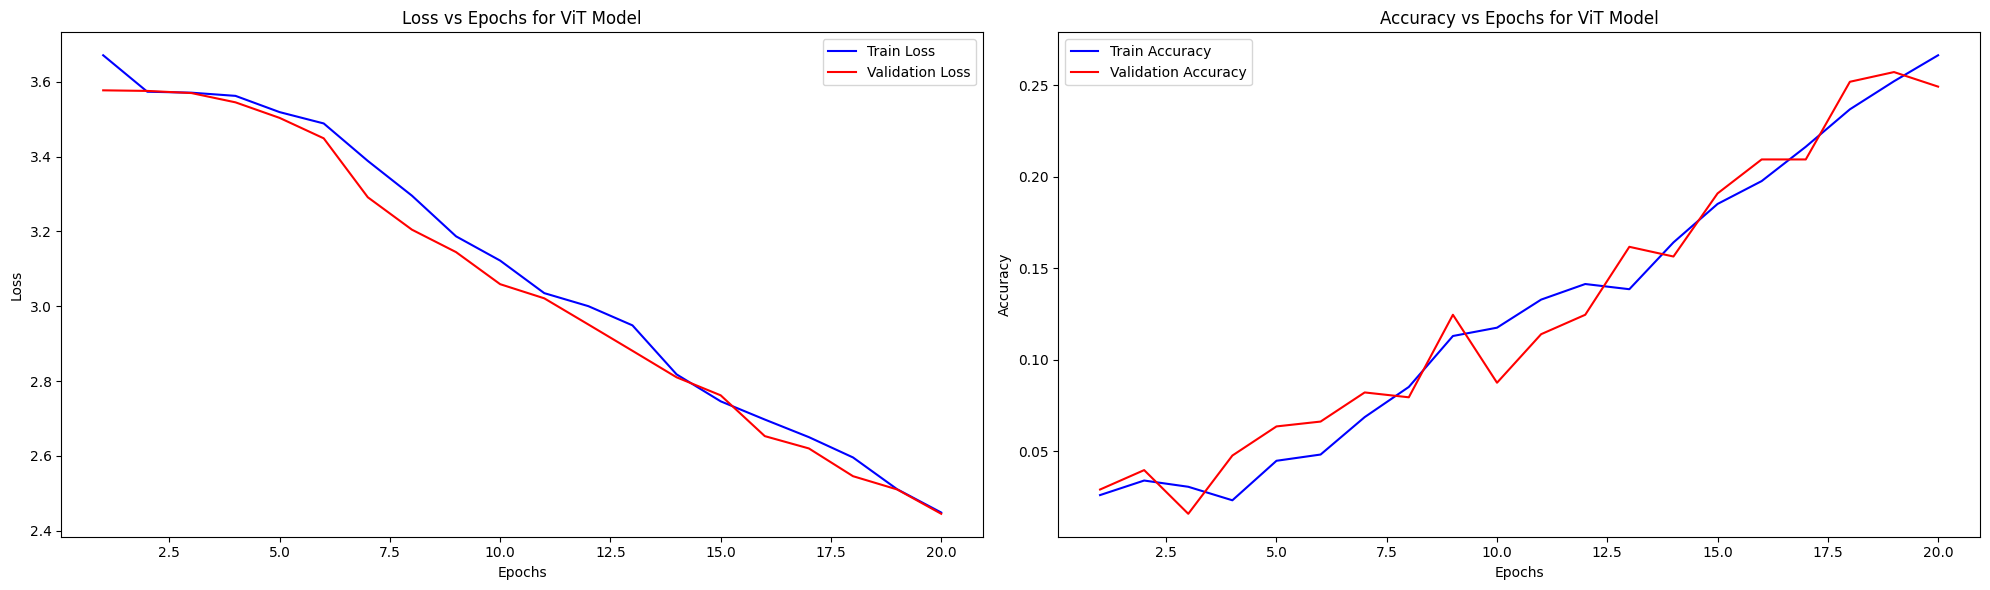

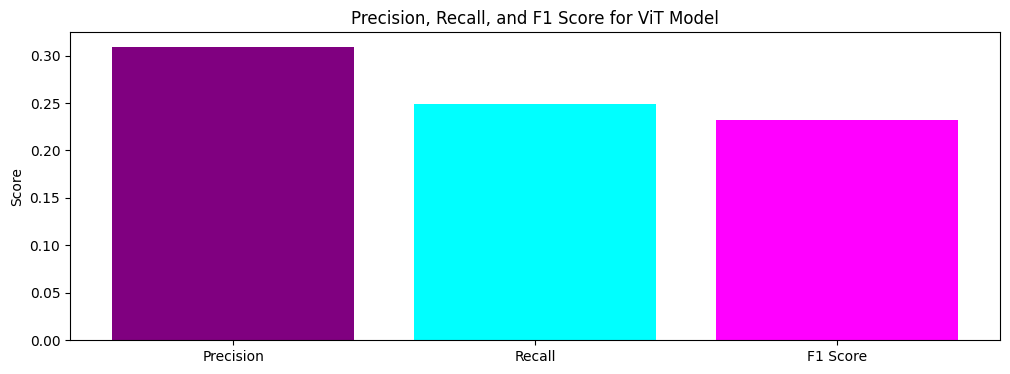

In [38]:
# Extract metrics from the History object
epochs = range(1, len(vit_model_history.history['loss']) + 1)
train_loss = vit_model_history.history['loss']
val_loss = vit_model_history.history['val_loss']
train_accuracy = vit_model_history.history['accuracy']
val_accuracy = vit_model_history.history['val_accuracy']

# Plot Loss and Accuracy vs Epochs
plt.figure(figsize=(20, 6))

# Loss vs Epochs
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Train Loss', color='blue')
plt.plot(epochs, val_loss, label='Validation Loss', color='red')
plt.title('Loss vs Epochs for ViT Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy vs Epochs
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, label='Train Accuracy', color='blue')
plt.plot(epochs, val_accuracy, label='Validation Accuracy', color='red')
plt.title('Accuracy vs Epochs for ViT Model')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Assuming 'metrics_vit' dictionary is already defined
precision = metrics_vit['precision_vit']
recall = metrics_vit['recall_vit']
f1 = metrics_vit['f1_score_vit']

# Plot Precision, Recall, and F1 Score
plt.figure(figsize=(12, 4))
plt.bar(['Precision', 'Recall', 'F1 Score'], 
        [precision, recall, f1],
        color=['purple', 'cyan', 'magenta'])
plt.title('Precision, Recall, and F1 Score for ViT Model')
plt.ylabel('Score')

plt.show()

In [39]:
X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size =0.2, random_state= 42)


# Evaluate the model on the validation set
val_loss, val_accuracy = vit_model.evaluate(X_val, y_val)
print(f"Validation accuracy: {val_accuracy}")

def create_simple_vit_model(input_shape, num_classes, patch_size=32, projection_dim=64, num_heads=4, transformer_units=[128], mlp_head_units=[128]):
    num_patches = (input_shape[0] // patch_size) * (input_shape[1] // patch_size)
    
    inputs = keras.Input(shape=input_shape)
    
    # Create patches
    patches = layers.Conv2D(filters=projection_dim, kernel_size=patch_size, strides=patch_size, padding='valid')(inputs)
    patches = layers.Reshape((num_patches, projection_dim))(patches)
    
    # Add positional embedding
    positions = tf.range(start=0, limit=num_patches, delta=1)
    positional_embedding = layers.Embedding(input_dim=num_patches, output_dim=projection_dim)(positions)
    encoded_patches = patches + positional_embedding

    # Create transformer block
    for units in transformer_units:
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim)(x1, x1)
        x2 = layers.Add()([attention_output, encoded_patches])
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = layers.Dense(units=units, activation=tf.nn.gelu)(x3)
        
        # Project x3 back to projection_dim
        x3 = layers.Dense(units=projection_dim)(x3)
        
        encoded_patches = layers.Add()([x3, x2])
    # Final MLP head
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    for units in mlp_head_units:
        representation = layers.Dense(units=units, activation=tf.nn.gelu)(representation)
    logits = layers.Dense(num_classes)(representation)
    
    return keras.Model(inputs=inputs, outputs=logits)

# Define input shape based on your data
input_shape = X_train.shape[1:]  # Assuming X_train is a 4D array (samples, height, width, channels)
num_classes = y_encoded.shape[1]  # Adjust this according to the number of classes in y_train

# Create the model
# Define the model
vit_model_1 = create_simple_vit_model(input_shape=input_shape, num_classes=num_classes)

# Compile the model
vit_model_1.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4),
                  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

# Fit the model
vit_model_1_history = vit_model_1.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=32)

# Evaluate the model
test_loss, test_accuracy = vit_model_1.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')
# Assuming X_test and y_test are already defined and preprocessed
test_loss, test_accuracy = vit_model_1.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.2620 - loss: 2.4086
Validation accuracy: 0.2763419449329376
Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 97ms/step - accuracy: 0.0748 - loss: 3.5848 - val_accuracy: 0.1429 - val_loss: 2.9777
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.1746 - loss: 2.8356 - val_accuracy: 0.2831 - val_loss: 2.4944
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.3373 - loss: 2.3141 - val_accuracy: 0.3783 - val_loss: 2.1584
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4670 - loss: 1.8788 - val_accuracy: 0.4524 - val_loss: 1.9312
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5455 - loss: 1.6417 - val_accuracy: 0.4894 - val_loss: 1.7879
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6175 - loss: 1.4104 - val_accuracy: 0.5344 - val_loss: 1.6089
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6638 - loss: 1.2234 - val_accuracy: 0.5397 - val_loss: 1.4

In [40]:
# Predict on the validation set
y_val_pred_probs = vit_model_1.predict(X_val)
y_val_pred = np.argmax(y_val_pred_probs, axis=1)
y_val_true = np.argmax(y_val, axis=1)  # Convert one-hot encoded labels to class labels

# Calculate precision, recall, and F1 score
precision = precision_score(y_val_true, y_val_pred, average='weighted')
recall = recall_score(y_val_true, y_val_pred, average='weighted')
f1 = f1_score(y_val_true, y_val_pred, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Save all metrics in a dictionary
metrics_vit_1 = {
    'test_loss_vit': test_loss,
    'test_accuracy_vit': test_accuracy,
    'val_loss_vit': val_loss,
    'val_accuracy_vit': val_accuracy,
    'precision_vit': precision,
    'recall_vit': recall,
    'f1_score_vit': f1
}


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step
Precision: 0.6181506337616887
Recall: 0.5984095427435387
F1 Score: 0.5952092213124601


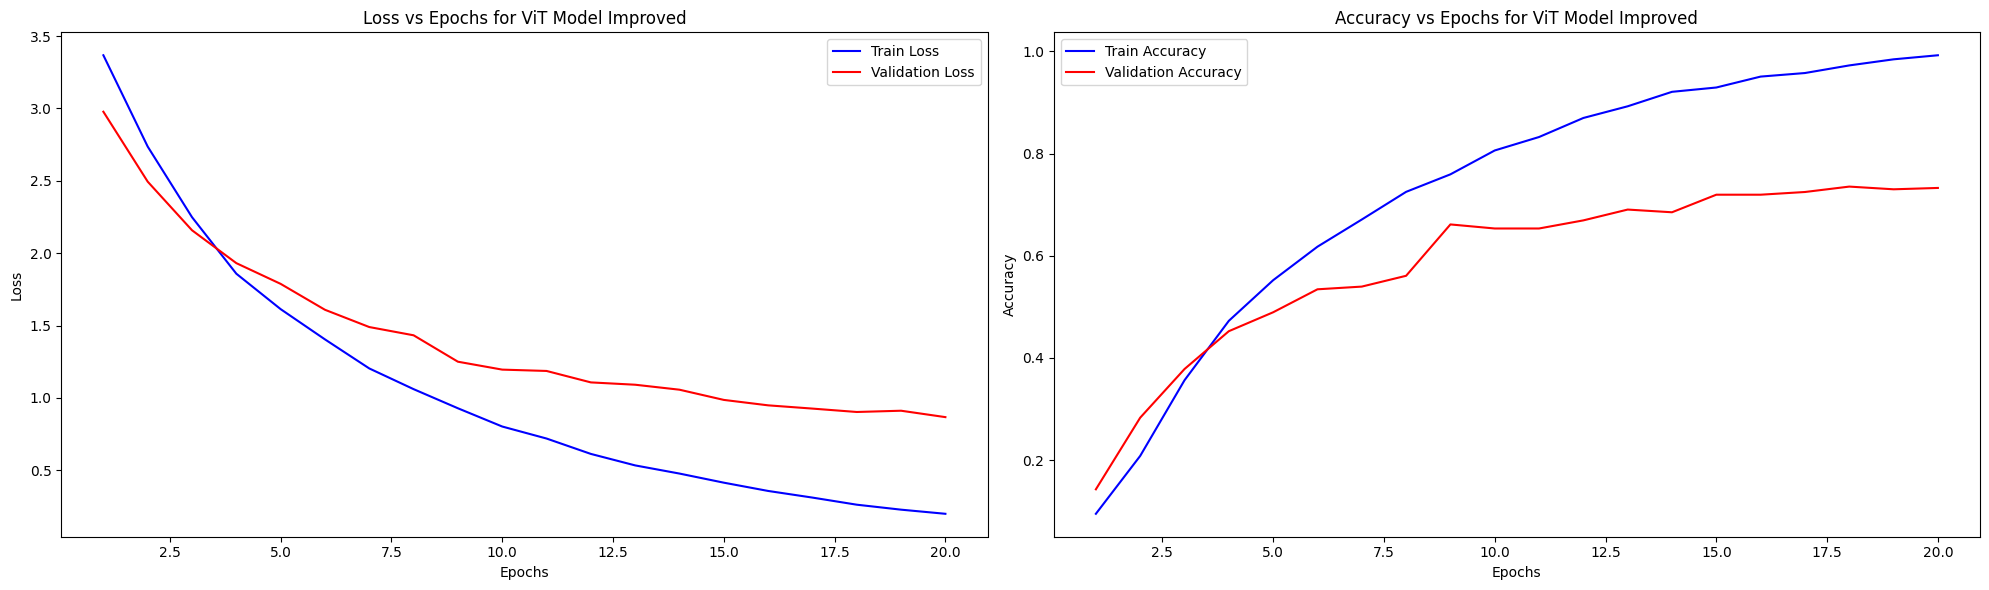

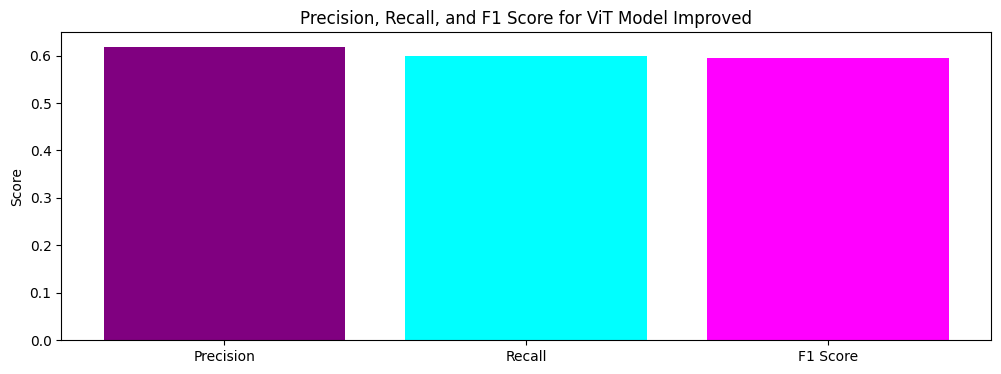

In [41]:
# Extract metrics from the History object
epochs = range(1, len(vit_model_1_history.history['loss']) + 1)
train_loss = vit_model_1_history.history['loss']
val_loss = vit_model_1_history.history['val_loss']
train_accuracy = vit_model_1_history.history['accuracy']
val_accuracy = vit_model_1_history.history['val_accuracy']

# Plot Loss and Accuracy vs Epochs
plt.figure(figsize=(20, 6))

# Loss vs Epochs
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Train Loss', color='blue')
plt.plot(epochs, val_loss, label='Validation Loss', color='red')
plt.title('Loss vs Epochs for ViT Model Improved')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy vs Epochs
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, label='Train Accuracy', color='blue')
plt.plot(epochs, val_accuracy, label='Validation Accuracy', color='red')
plt.title('Accuracy vs Epochs for ViT Model Improved')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Assuming 'metrics_vit' dictionary is already defined
precision = metrics_vit_1['precision_vit']
recall = metrics_vit_1['recall_vit']
f1 = metrics_vit_1['f1_score_vit']

# Plot Precision, Recall, and F1 Score
plt.figure(figsize=(12, 4))
plt.bar(['Precision', 'Recall', 'F1 Score'], 
        [precision, recall, f1],
        color=['purple', 'cyan', 'magenta'])
plt.title('Precision, Recall, and F1 Score for ViT Model Improved')
plt.ylabel('Score')

plt.show()

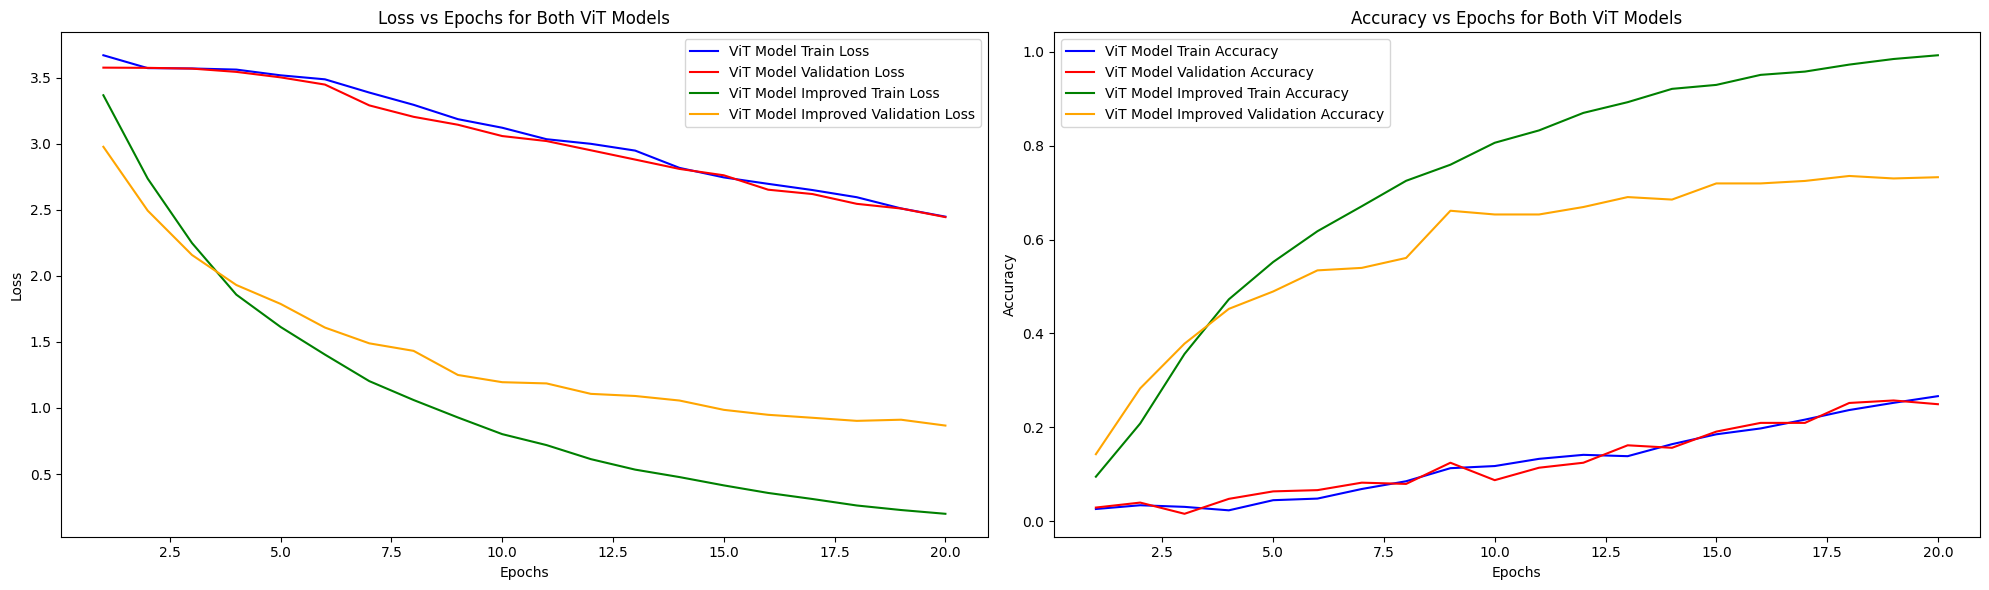

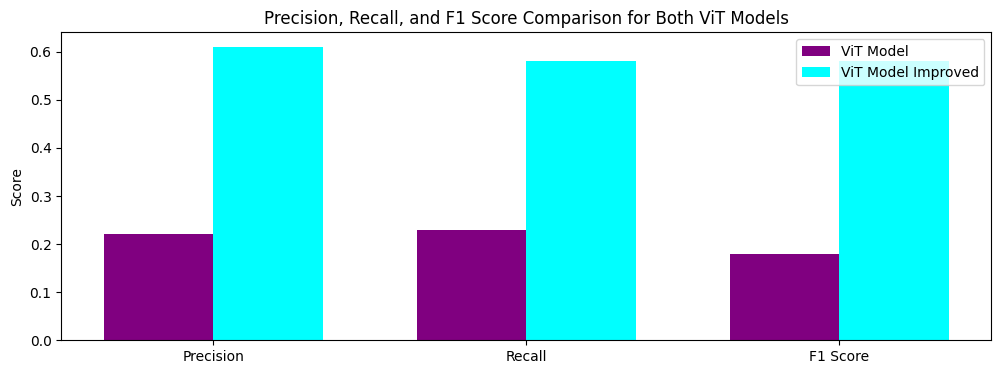

In [42]:
# Metrics from ViT Model 1 training
epochs_vit_1 = range(1, len(vit_model_history.history['loss']) + 1)
train_loss_vit_1 = vit_model_history.history['loss']
val_loss_vit_1 = vit_model_history.history['val_loss']
train_accuracy_vit_1 = vit_model_history.history['accuracy']
val_accuracy_vit_1 = vit_model_history.history['val_accuracy']

# Metrics from ViT Model 2 training
epochs_vit_2 = range(1, len(vit_model_1_history.history['loss']) + 1)
train_loss_vit_2 = vit_model_1_history.history['loss']
val_loss_vit_2 = vit_model_1_history.history['val_loss']
train_accuracy_vit_2 = vit_model_1_history.history['accuracy']
val_accuracy_vit_2 = vit_model_1_history.history['val_accuracy']

# Plot Loss and Accuracy for both ViT models
plt.figure(figsize=(20, 6))

# Loss vs Epochs
plt.subplot(1, 2, 1)
plt.plot(epochs_vit_1, train_loss_vit_1, label='ViT Model Train Loss', color='blue')
plt.plot(epochs_vit_1, val_loss_vit_1, label='ViT Model Validation Loss', color='red')
plt.plot(epochs_vit_2, train_loss_vit_2, label='ViT Model Improved Train Loss', color='green')
plt.plot(epochs_vit_2, val_loss_vit_2, label='ViT Model Improved Validation Loss', color='orange')
plt.title('Loss vs Epochs for Both ViT Models')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy vs Epochs
plt.subplot(1, 2, 2)
plt.plot(epochs_vit_1, train_accuracy_vit_1, label='ViT Model Train Accuracy', color='blue')
plt.plot(epochs_vit_1, val_accuracy_vit_1, label='ViT Model Validation Accuracy', color='red')
plt.plot(epochs_vit_2, train_accuracy_vit_2, label='ViT Model Improved Train Accuracy', color='green')
plt.plot(epochs_vit_2, val_accuracy_vit_2, label='ViT Model Improved Validation Accuracy', color='orange')
plt.title('Accuracy vs Epochs for Both ViT Models')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Assuming metrics for both ViT models are defined in dictionaries
metrics_vit_1 = {'precision': 0.22, 'recall': 0.23, 'f1_score': 0.18}  
metrics_vit_improved = {'precision': 0.61, 'recall': 0.58, 'f1_score': 0.58}

# Plot Precision, Recall, and F1 Score for both ViT models
plt.figure(figsize=(12, 4))

# Define metrics for both models
metrics_vit_1_values = [metrics_vit_1['precision'], metrics_vit_1['recall'], metrics_vit_1['f1_score']]
metrics_vit_imp_values = [metrics_vit_improved['precision'], metrics_vit_improved['recall'], metrics_vit_improved['f1_score']]

bar_width = 0.35
index = range(len(metrics_vit_1_values))

# Plot bar chart for Precision, Recall, and F1 Score
plt.bar(index, metrics_vit_1_values, bar_width, label='ViT Model', color='purple')
plt.bar([i + bar_width for i in index], metrics_vit_imp_values, bar_width, label='ViT Model Improved', color='cyan')

plt.xticks([i + bar_width / 2 for i in index], ['Precision', 'Recall', 'F1 Score'])
plt.title('Precision, Recall, and F1 Score Comparison for Both ViT Models')
plt.ylabel('Score')
plt.legend()

plt.show()